# **0. Importion**

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Standard Library
import random
from datetime import datetime

# Third-Party Data Handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    precision_recall_fscore_support
)
from sklearn.linear_model import LogisticRegression
# Gradient Boosting
import xgboost as xgb

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.metrics import fbeta_score, f1_score
from tensorflow.keras.layers import LSTM, Dense

# Specialized Encoders
from category_encoders import TargetEncoder

# **1. Load Dataset**

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "combined_creditcard_data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "abdelrahmanmahmoud22/final-deep-gans-data",
  file_path,
)

print("First 5 records:", df.head())

/tmp/ipykernel_2466/2723287893.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:   trans_date_trans_time           cc_num                    merchant  \
0   2019-01-02 01:06:37    4613314721966            Rutherford-Mertz   
1   2019-01-02 01:47:29  340187018810220  Jenkins, Hauck and Friesen   
2   2019-01-02 03:05:23  340187018810220            Goodwin-Nitzsche   
3   2019-01-02 03:38:03    4613314721966            Erdman-Kertzmann   
4   2019-01-02 03:55:47  340187018810220                Koepp-Parker   

        category     amt  gender           city state  city_pop  is_fraud  \
0    grocery_pos  281.00       0  Collettsville    NC       885         1   
1  gas_transport   11.52       1    San Antonio    TX   1595797         1   
2    grocery_pos  276.20       1    San Antonio    TX   1595797         1   
3  gas_transport    7.03       0  Collettsville    NC       885         1   
4    grocery_pos  275.80       1    San Antonio    TX   1595797         1   

   age Region job_category  
0   31  South   Technology  
1   59  South   Technology  


# **2. Feture Engineering**

In [6]:
# Ensure trans_date_trans_time is datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# Filter adults
df = df[df['age'] >= 18]

# Equal frequency binning for age
num_bins = 4
age_labels = ['Young', 'Middle-aged', 'Senior', 'Elder']
df['age_group'] = pd.qcut(df['age'], q=num_bins, labels=age_labels)

df["trans_year"] = pd.Series(pd.to_datetime(df.trans_date_trans_time)).dt.year

# Is it weekend?
df["is_weekend"] = df["trans_date_trans_time"].dt.day_name().apply(lambda x: int((x == "Sunday") | (x == "Saturday")))

# Day period
def day_period(x):
    if 0 <= x < 6: return "Night"
    elif 6 <= x < 12: return "Morning"
    elif 12 <= x < 18: return "Afternoon"
    elif 18 <= x < 24: return "Evening"

df["day_period"] = df["trans_date_trans_time"].dt.hour.apply(day_period)
# Extract month and day name
df["trans_month"] = df["trans_date_trans_time"].dt.month_name()
df['day_name'] = df['trans_date_trans_time'].dt.day_name()

# **3. Transformation**

In [7]:
X = df.drop(columns=['is_fraud'], axis=1)
y = df['is_fraud']

# Identify columns
num_cols = ['amt', 'city_pop', 'age', 'trans_year']
high_card_cols = ['merchant', 'category', 'job_category','state']
low_card_cols = ['Region', 'day_period', 'age_group', 'trans_month', 'day_name']
ready_cols = ['gender', 'is_weekend']


encoder = TargetEncoder()
X_high = encoder.fit_transform(X[high_card_cols], y)


X_low = pd.get_dummies(X[low_card_cols], drop_first=True)


scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[num_cols]), columns=num_cols, index=X.index)


X_ready = X[ready_cols].copy()


X_processed = pd.concat([X_num, X_high, X_low, X_ready], axis=1)

# **4. Splitting the data**

In [8]:
def set_seed(seed=42):
    random.seed(seed)                    # Python random seed
    np.random.seed(seed)                 # NumPy random seed
    tf.random.set_seed(seed)             # TensorFlow random seed

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **5. Modelling**

## 5.0 Model Evaluation functions

#### **5.0.1 Machine Learning Evaluatoin function**

In [10]:
# ML Evaluatoin report function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Predicted probabilities
    y_test_proba = model.predict_proba(X_test)[:, 1]
    y_train_proba = model.predict_proba(X_train)[:, 1]

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Get classification report as dictionary
    report_dict = classification_report(y_test, y_test_pred, output_dict=True)

    # Create a 3x3 grid for all visualizations
    plt.figure(figsize=(20, 15))
    plt.suptitle(f"{model_name} Evaluation Dashboard", fontsize=16, y=1.02)

    # Confusion Matrix
    plt.subplot(3, 3, 1)
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # ROC Curve
    plt.subplot(3, 3, 2)
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    plt.subplot(3, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    plt.plot(recall, precision, color='darkorange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")

    # Cumulative Gains Chart
    plt.subplot(3, 3, 4)
    sorted_idx = np.argsort(-y_test_proba)
    gains_y = np.array(y_test)[sorted_idx]
    cumulative_gains = np.cumsum(gains_y) / np.sum(gains_y)
    percentage_samples = np.arange(1, len(gains_y) + 1) / len(gains_y)
    plt.plot(percentage_samples, cumulative_gains, label="Model")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Baseline")
    plt.xlabel("Proportion of Samples")
    plt.ylabel("Proportion of Positives Captured")
    plt.title("Cumulative Gains Chart")
    plt.legend()

    # Predicted Probability Distribution
    plt.subplot(3, 3, 5)
    sns.histplot(y_test_proba, bins=50, kde=True)
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")

    # Overfitting Check
    plt.subplot(3, 3, 6)
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['blue', 'orange'])
    plt.title("Accuracy Comparison")
    plt.ylim(0, 1)

    # Classification Report Table with highlighted class 1
    plt.subplot(3, 3, (7, 9))
    # Prepare data for the table
    metrics = ['precision', 'recall', 'f1-score', 'support']
    classes = list(report_dict.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    cell_text = []

    for cls in classes:
        row = [report_dict[cls][metric] for metric in metrics[:-1]]  # Exclude support
        cell_text.append([f"{x:.2f}" for x in row])

    # Add support separately (as integer)
    support = [int(report_dict[cls]['support']) for cls in classes]
    for i, val in enumerate(support):
        cell_text[i].append(str(val))

    # Add averages
    avg_names = ['macro avg', 'weighted avg']
    for name in avg_names:
        row = [report_dict[name][metric] for metric in metrics[:-1]]
        cell_text.append([f"{x:.2f}" for x in row] + [str(int(report_dict[name]['support']))])

    # Create table
    table = plt.table(cellText=cell_text,
                     rowLabels=classes + avg_names,
                     colLabels=metrics,
                     loc='center',
                     cellLoc='center')

    # Style the table - larger font and highlight class 1
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Increased from 10 to 12

    # Highlight class 1 row (assuming it's labeled '1' or 'positive')
    class_1_label = '1' if '1' in classes else ('positive' if 'positive' in classes else None)

    if class_1_label:
        class_1_idx = classes.index(class_1_label)
        for j in range(len(metrics)):
            table[(class_1_idx+1, j)].set_facecolor('#FFFACD')  # Light yellow background
            table[(class_1_idx+1, j)].set_fontsize(14)  # Even larger font for class 1

    # Highlight header
    for j in range(len(metrics)):
        table[(0, j)].set_facecolor('#E6E6FA')  # Light purple for header
        table[(0, j)].set_fontsize(12)

    table.scale(1, 1.5)
    plt.axis('off')
    plt.title("Classification Report (Class 1 Highlighted)", fontsize=14)

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_test_pred))
    print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    print(f"{model_name} Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} Test Accuracy:  {test_acc:.4f}")

    diff = train_acc - test_acc
    if diff > 0.03:
        print(f"Overfitting detected: Training accuracy is higher by {diff:.2%}")
    elif diff < -0.03:
        print(f"Underfitting or data issue: Test accuracy is higher by {-diff:.2%}")
    else:
        print("No overfitting: Training and test accuracies are close.")

#### **5.0.2 Neural Network Evaluatoin function**

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
# Make sure you have tensorflow/keras installed for the example
# pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def evaluate_nn_model(model, X_train, y_train, X_test, y_test, model_name="Neural Network",
                      history=None, save_individual_charts=False, output_dir='evaluation_reports'):
    """
    Generates a comprehensive evaluation report for a Neural Network model,
    including a dashboard of plots and optional saving of individual charts.

    Args:
        model: The trained Keras/TensorFlow model.
        X_train, y_train: Training data and labels.
        X_test, y_test: Test data and labels.
        model_name (str): The name of the model for titles and filenames.
        history: The history object returned from model.fit().
        save_individual_charts (bool): If True, saves each plot as a separate
                                       image file in a dedicated directory.
        output_dir (str): The parent directory to save the report folder in.
    """
    # --- 1. PREDICTIONS & METRICS ---
    # Note: Flatten is important for Keras's output shape (batch_size, 1)
    y_test_proba = model.predict(X_test).flatten()
    y_train_proba = model.predict(X_train).flatten()
    y_test_pred = (y_test_proba > 0.5).astype("int32")
    y_train_pred = (y_train_proba > 0.5).astype("int32")

    # Calculate metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_proba)

    # --- 2. DIRECTORY SETUP FOR SAVING CHARTS ---
    report_path = None
    if save_individual_charts:
        sanitized_model_name = model_name.replace(" ", "_").lower()
        report_path = os.path.join(output_dir, sanitized_model_name)
        os.makedirs(report_path, exist_ok=True)
        print(f"Saving individual charts to: {report_path}")

    # --- 3. CREATE THE MAIN 3x3 DASHBOARD ---
    fig_main, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig_main.suptitle(f"{model_name} Evaluation Dashboard", fontsize=16, y=1.02)
    ax = axes.ravel() # Flatten the 3x3 grid to a 1D array of 9 axes

    # --- Plot 1: Confusion Matrix ---
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
    ax[0].set_title("Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax_single)
        ax_single.set_title("Confusion Matrix")
        ax_single.set_xlabel("Predicted")
        ax_single.set_ylabel("Actual")
        fig.savefig(os.path.join(report_path, '1_confusion_matrix.png'))
        plt.close(fig)

    # --- Plot 2: ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    ax[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend()
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        ax_single.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
        ax_single.plot([0, 1], [0, 1], 'k--')
        ax_single.set_xlabel("False Positive Rate")
        ax_single.set_ylabel("True Positive Rate")
        ax_single.set_title("ROC Curve")
        ax_single.legend()
        fig.savefig(os.path.join(report_path, '2_roc_curve.png'))
        plt.close(fig)

    # --- Plot 3: Precision-Recall Curve ---
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    ax[2].plot(recall, precision, color='darkorange')
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].set_title("Precision-Recall Curve")
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        ax_single.plot(recall, precision, color='darkorange')
        ax_single.set_xlabel("Recall")
        ax_single.set_ylabel("Precision")
        ax_single.set_title("Precision-Recall Curve")
        fig.savefig(os.path.join(report_path, '3_precision_recall_curve.png'))
        plt.close(fig)

    # --- Plot 4: Cumulative Gains Chart ---
    sorted_idx = np.argsort(-y_test_proba)
    gains_y = np.array(y_test)[sorted_idx]
    cumulative_gains = np.cumsum(gains_y) / np.sum(gains_y)
    percentage_samples = np.arange(1, len(gains_y) + 1) / len(gains_y)
    ax[3].plot(percentage_samples, cumulative_gains, label="Model")
    ax[3].plot([0, 1], [0, 1], linestyle='--', label="Baseline")
    ax[3].set_xlabel("Proportion of Samples")
    ax[3].set_ylabel("Proportion of Positives Captured")
    ax[3].set_title("Cumulative Gains Chart")
    ax[3].legend()
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        ax_single.plot(percentage_samples, cumulative_gains, label="Model")
        ax_single.plot([0, 1], [0, 1], linestyle='--', label="Baseline")
        ax_single.set_xlabel("Proportion of Samples")
        ax_single.set_ylabel("Proportion of Positives Captured")
        ax_single.set_title("Cumulative Gains Chart")
        ax_single.legend()
        fig.savefig(os.path.join(report_path, '4_cumulative_gains_chart.png'))
        plt.close(fig)

    # --- Plot 5: Predicted Probability Distribution ---
    sns.histplot(y_test_proba, bins=50, kde=True, ax=ax[4])
    ax[4].set_title("Predicted Probability Distribution")
    ax[4].set_xlabel("Predicted Probability")
    ax[4].set_ylabel("Frequency")
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        sns.histplot(y_test_proba, bins=50, kde=True, ax=ax_single)
        ax_single.set_title("Predicted Probability Distribution")
        ax_single.set_xlabel("Predicted Probability")
        ax_single.set_ylabel("Frequency")
        fig.savefig(os.path.join(report_path, '5_probability_distribution.png'))
        plt.close(fig)

    # --- Plots 6 & 7: Accuracy/Loss History (if available) ---
    if history is not None:
        # Accuracy history
        ax[5].plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            ax[5].plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax[5].set_title('Model Accuracy over Epochs')
        ax[5].set_ylabel('Accuracy')
        ax[5].set_xlabel('Epoch')
        ax[5].legend()
        if save_individual_charts:
            fig, ax_single = plt.subplots()
            ax_single.plot(history.history['accuracy'], label='Train Accuracy')
            if 'val_accuracy' in history.history:
                ax_single.plot(history.history['val_accuracy'], label='Validation Accuracy')
            ax_single.set_title('Model Accuracy over Epochs')
            ax_single.set_ylabel('Accuracy')
            ax_single.set_xlabel('Epoch')
            ax_single.legend()
            fig.savefig(os.path.join(report_path, '6_training_accuracy.png'))
            plt.close(fig)

        # Loss history
        ax[6].plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            ax[6].plot(history.history['val_loss'], label='Validation Loss')
        ax[6].set_title('Model Loss over Epochs')
        ax[6].set_ylabel('Loss')
        ax[6].set_xlabel('Epoch')
        ax[6].legend()
        if save_individual_charts:
            fig, ax_single = plt.subplots()
            ax_single.plot(history.history['loss'], label='Train Loss')
            if 'val_loss' in history.history:
                ax_single.plot(history.history['val_loss'], label='Validation Loss')
            ax_single.set_title('Model Loss over Epochs')
            ax_single.set_ylabel('Loss')
            ax_single.set_xlabel('Epoch')
            ax_single.legend()
            fig.savefig(os.path.join(report_path, '7_training_loss.png'))
            plt.close(fig)

    # --- Plot 8: Overfitting Check ---
    ax[7].bar(['Train', 'Test'], [train_acc, test_acc], color=['blue', 'orange'])
    ax[7].set_title("Final Accuracy Comparison")
    ax[7].set_ylim(0, 1)
    if save_individual_charts:
        fig, ax_single = plt.subplots()
        ax_single.bar(['Train', 'Test'], [train_acc, test_acc], color=['blue', 'orange'])
        ax_single.set_title("Final Accuracy Comparison")
        ax_single.set_ylim(0, 1)
        fig.savefig(os.path.join(report_path, '8_accuracy_comparison.png'))
        plt.close(fig)

    # Hide any unused subplots
    for i in range(len(ax)):
        if not ax[i].has_data():
            ax[i].axis('off')

    # --- 4. FINALIZE AND SHOW DASHBOARD & PRINT METRICS ---
    fig_main.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Print summary
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_test_pred))
    print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Test Accuracy:  {test_acc:.4f}")

    diff = train_acc - test_acc
    if diff > 0.05: # Using a 5% threshold
        print(f"Potential overfitting: Training accuracy is higher by {diff:.2%}")
    elif diff < -0.05:
        print(f"Potential underfitting or data issue: Test accuracy is higher by {-diff:.2%}")
    else:
        print("No significant overfitting/underfitting detected.")

### **5.0.3 LSTM Evaluation Function**

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

def evaluate_sequences_model(model, X_train_seq, y_train_labels, X_test_seq, y_test_labels, history=None, model_name="Sequence Model"):
    """
    Provides a comprehensive evaluation for a trained Keras sequence model (LSTM, GRU, RNN).

    Args:
        model (keras.Model): The trained Keras model.
        X_train_seq (np.array): Training data, must be in 3D sequence format (samples, timesteps, features).
        y_train_labels (np.array): Training labels.
        X_test_seq (np.array): Test data, must be in 3D sequence format.
        y_test_labels (np.array): Test labels.
        history (keras.callbacks.History, optional): History object from model.fit(). Defaults to None.
        model_name (str, optional): Name of the model for titles. Defaults to "Sequence Model".
    """
    print(f"--- Evaluating {model_name} ---")

    # 1. --- EFFICIENT PREDICTIONS ---
    # Get predicted probabilities once and derive labels from them
    y_test_proba = model.predict(X_test_seq).flatten()
    y_train_proba = model.predict(X_train_seq).flatten()
    
    y_test_pred = (y_test_proba > 0.5).astype("int32")
    y_train_pred = (y_train_proba > 0.5).astype("int32")

    # 2. --- CLASSIFICATION METRICS ---
    train_acc = accuracy_score(y_train_labels, y_train_pred)
    test_acc = accuracy_score(y_test_labels, y_test_pred)
    roc_auc = roc_auc_score(y_test_labels, y_test_proba)
    
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test_labels, y_test_pred))

    # 3. --- VISUALIZATIONS ---
    # Determine grid size based on whether history is available
    if history is not None:
        fig, axes = plt.subplots(2, 4, figsize=(24, 12))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_test_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, y_test_proba)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"ROC Curve")
    axes[1].legend()

    # Plot 3: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_labels, y_test_proba)
    axes[2].plot(recall, precision, color='darkorange')
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title(f"Precision-Recall Curve")

    # Plot 4: Cumulative Gains Chart
    # Sort probabilities and true labels
    sorted_indices = np.argsort(y_test_proba)[::-1]
    sorted_y_test = y_test_labels[sorted_indices]
    cumulative_gains = np.cumsum(sorted_y_test) / np.sum(sorted_y_test)
    percentage_samples = np.linspace(0, 1, len(cumulative_gains))
    axes[3].plot(percentage_samples, cumulative_gains, label="Model")
    axes[3].plot([0, 1], [0, 1], linestyle='--', color='grey', label="Baseline")
    axes[3].set_xlabel("Proportion of Samples")
    axes[3].set_ylabel("Proportion of Positives Captured")
    axes[3].set_title(f"Cumulative Gains Chart")
    axes[3].legend()

    # Plot 5: Predicted Probability Distribution
    sns.histplot(y_test_proba, bins=50, kde=True, ax=axes[4])
    axes[4].set_title(f"Predicted Probability Distribution")
    axes[4].set_xlabel("Predicted Probability")
    axes[4].set_ylabel("Frequency")

    # Plot 6: Overfitting Check (Train vs. Test Accuracy)
    axes[5].bar(['Train', 'Test'], [train_acc, test_acc], color=['#1f77b4', '#ff7f0e'])
    axes[5].set_title(f"Accuracy: Train vs. Test")
    axes[5].set_ylim(0, 1.05)
    for i, acc in enumerate([train_acc, test_acc]):
        axes[5].text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontweight='bold')

    # Plots 7 & 8: Training History (if available)
    if history is not None:
        # Accuracy History
        axes[6].plot(history.history['accuracy'], label='Train Accuracy')
        axes[6].plot(history.history['val_accuracy'], label='Validation Accuracy')
        axes[6].set_title(f'Accuracy over Epochs')
        axes[6].set_xlabel('Epoch')
        axes[6].set_ylabel('Accuracy')
        axes[6].legend()
        axes[6].grid(True, alpha=0.3)

        # Loss History
        axes[7].plot(history.history['loss'], label='Train Loss')
        axes[7].plot(history.history['val_loss'], label='Validation Loss')
        axes[7].set_title(f'Loss over Epochs')
        axes[7].set_xlabel('Epoch')
        axes[7].set_ylabel('Loss')
        axes[7].legend()
        axes[7].grid(True, alpha=0.3)
    
    # In case there are more axes than plots (when history is None)
    for i in range(len(axes)):
        if not axes[i].has_data():
            fig.delaxes(axes[i])

    fig.suptitle(f"{model_name} - Comprehensive Evaluation", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

    # 4. --- FINAL METRICS & ANALYSIS ---
    print(f"\n{model_name} Final Metrics:")
    print(f"-> ROC AUC Score: {roc_auc:.4f}")
    print(f"-> Train Accuracy: {train_acc:.4f}")
    print(f"-> Test Accuracy:  {test_acc:.4f}")
    
    diff = train_acc - test_acc
    if diff > 0.05: # A 5% threshold is often reasonable
        print(f"-> Potential Overfitting: Training accuracy is higher by {diff:.2%}")
    elif diff < -0.03:
        print(f"-> Potential Data Mismatch or Underfitting: Test accuracy is higher by {-diff:.2%}")
    else:
        print("-> Good Generalization: Training and test accuracies are close.")

#### **5.0.4 Autoencoder Evaluatoin function**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
)

def evaluate_autoencoder_model(model, X_test_flat, y_test_labels, threshold, history=None, model_name="Autoencoder"):
    """
    Provides a comprehensive evaluation for a trained Keras autoencoder used for anomaly detection.

    Args:
        model (keras.Model): The trained autoencoder model.
        X_test_flat (np.array): Flattened 2D test data.
        y_test_labels (np.array): The true labels for the test data.
        threshold (float): The reconstruction error threshold for classifying anomalies.
        history (keras.callbacks.History, optional): History object from model.fit(). Defaults to None.
        model_name (str, optional): Name of the model for titles. Defaults to "Autoencoder".
    """
    print(f"--- Evaluating {model_name} ---")

    # 1. --- GET RECONSTRUCTION ERRORS (ANOMALY SCORES) ---
    reconstructions = model.predict(X_test_flat)
    
    mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    reconstruction_errors = mse_fn(reconstructions, X_test_flat).numpy()
    
    # 2. --- GENERATE PREDICTIONS BASED ON THRESHOLD ---
    y_pred_labels = (reconstruction_errors > threshold).astype(int)

    # 3. --- CLASSIFICATION METRICS ---
    roc_auc = roc_auc_score(y_test_labels, reconstruction_errors)
    
    print(f"\n{model_name} Classification Report (Threshold: {threshold:.4f}):\n")
    print(classification_report(y_test_labels, y_pred_labels))

    # 4. --- VISUALIZATIONS ---
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    # Plot 1: Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", ax=axes[0], annot_kws={"size": 14})
    axes[0].set_title(f"Confusion Matrix")
    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")

    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_test_labels, reconstruction_errors)
    axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='blue')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title(f"ROC Curve")
    axes[1].legend()

    # Plot 3: Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_labels, reconstruction_errors)
    axes[2].plot(recall, precision, color='purple')
    axes[2].set_xlabel("Recall")
    axes[2].set_ylabel("Precision")
    axes[2].set_title(f"Precision-Recall Curve")
    
    # Plot 4: Reconstruction Error Distribution (VERY IMPORTANT for AE)
    errors_normal = reconstruction_errors[y_test_labels == 0]
    errors_anomaly = reconstruction_errors[y_test_labels == 1]
    sns.histplot(errors_normal, ax=axes[3], color='green', label='Normal', kde=True, bins=50)
    sns.histplot(errors_anomaly, ax=axes[3], color='red', label='Anomaly', kde=True, bins=50)
    axes[3].axvline(threshold, color='black', linestyle='--', label=f'Threshold = {threshold:.4f}')
    axes[3].set_title('Reconstruction Error Distribution')
    axes[3].set_xlabel('Reconstruction Error (MSE)')
    axes[3].legend()

    # Plot 5: Training History (Loss)
    if history is not None:
        axes[4].plot(history.history['loss'], label='Training Loss')
        axes[4].plot(history.history['val_loss'], label='Validation Loss')
        axes[4].set_title('Training & Validation Loss')
        axes[4].set_xlabel('Epoch')
        axes[4].set_ylabel('Loss (MSE)')
        axes[4].legend()
        axes[4].grid(True, alpha=0.3)
    else:
        # If no history, remove the empty plot for a cleaner look
        fig.delaxes(axes[4])

    # Plot 6 is intentionally left blank for better spacing if history is available.
    fig.delaxes(axes[5])

    fig.suptitle(f"{model_name} - Anomaly Detection Evaluation", fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

    # 5. --- FINAL METRICS ---
    print(f"\n{model_name} Final Metrics:")
    print(f"-> ROC AUC Score: {roc_auc:.4f}")

#### **5.0.4 RNN Evaluatoin function**

In [14]:
def evaluate_rnn_model(model, X_train_scaled, y_train, X_test_scaled, y_test, history=None, model_name="RNN Model"):
    # Reshape input for RNN: (samples, timesteps, features=1)
    X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    # Predict class labels
    y_test_pred = (model.predict(X_test_rnn) > 0.5).astype("int32").flatten()
    y_train_pred = (model.predict(X_train_rnn) > 0.5).astype("int32").flatten()

    # Predicted probabilities
    y_test_proba = model.predict(X_test_rnn).flatten()
    y_train_proba = model.predict(X_train_rnn).flatten()

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test, y_test_pred))

    # Create a single comprehensive figure with all evaluation plots
    # Adjust grid size based on whether history is available
    if history is not None:
        plt.figure(figsize=(24, 16))  # Larger figure to accommodate more plots
        subplot_rows, subplot_cols = 3, 4  # 3x4 grid for 8 plots
    else:
        plt.figure(figsize=(18, 12))
        subplot_rows, subplot_cols = 2, 3  # 2x3 grid for 6 plots

    # 1. Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_test_pred)
    plt.subplot(subplot_rows, subplot_cols, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = roc_auc_score(y_test, y_test_proba)
    plt.subplot(subplot_rows, subplot_cols, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curve")
    plt.legend()

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    plt.subplot(subplot_rows, subplot_cols, 3)
    plt.plot(recall, precision, color='darkorange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")

    # 4. Cumulative Gains Chart
    sorted_idx = np.argsort(-y_test_proba)
    gains_y = np.array(y_test)[sorted_idx]
    cumulative_gains = np.cumsum(gains_y) / np.sum(gains_y)
    percentage_samples = np.arange(1, len(gains_y) + 1) / len(gains_y)
    plt.subplot(subplot_rows, subplot_cols, 4)
    plt.plot(percentage_samples, cumulative_gains, label="Model")
    plt.plot([0, 1], [0, 1], linestyle='--', label="Baseline")
    plt.xlabel("Proportion of Samples")
    plt.ylabel("Proportion of Positives Captured")
    plt.title(f"{model_name} - Cumulative Gains Chart")
    plt.legend()

    # 5. Predicted Probability Distribution
    plt.subplot(subplot_rows, subplot_cols, 5)
    sns.histplot(y_test_proba, bins=50, kde=True)
    plt.title(f"{model_name} - Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")

    # 6. Overfitting Check
    plt.subplot(subplot_rows, subplot_cols, 6)
    plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['blue', 'orange'])
    plt.title(f"{model_name} - Overfitting Check")
    plt.ylim(0, 1)
    # Add percentage labels on bars
    plt.text(0, train_acc + 0.02, f"{train_acc:.2%}", ha='center', fontweight='bold')
    plt.text(1, test_acc + 0.02, f"{test_acc:.2%}", ha='center', fontweight='bold')

    # 7 & 8. Training History Plots (if available)
    if history is not None:
        # 7. Accuracy History
        plt.subplot(subplot_rows, subplot_cols, 7)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 8. Loss History
        plt.subplot(subplot_rows, subplot_cols, 8)
        plt.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} - Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

    # Add super title and adjust layout
    plt.suptitle(f"{model_name} Comprehensive Evaluation", fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    print(f"{model_name} Train Accuracy: {train_acc:.4f}")
    print(f"{model_name} Test Accuracy:  {test_acc:.4f}")

    # Overfitting analysis
    diff = train_acc - test_acc
    if diff > 0.03:
        print(f"Overfitting detected: Training accuracy is higher by {diff:.2%}")
    elif diff < -0.03:
        print(f"Underfitting or data issue: Test accuracy is higher by {-diff:.2%}")
    else:
        print("No overfitting: Training and test accuracies are close.")

## **5.1 Machine Learning**

### 5.1.1 Logistic regression

#### 5.1.1.1 Pure Logistic Regression

In [15]:
set_seed(42)
from sklearn.linear_model import LogisticRegression
# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression:
Accuracy: 0.8376
Confusion Matrix:
 [[507724  39210]
 [107138 247212]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.87    546934
           1       0.86      0.70      0.77    354350

    accuracy                           0.84    901284
   macro avg       0.84      0.81      0.82    901284
weighted avg       0.84      0.84      0.83    901284



In [16]:
lr_model.get_params()


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Logistic Grid search

Performing Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits



Best parameters found:  {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation ROC AUC score: 0.9034

Evaluating best Logistic Regression model on test set:


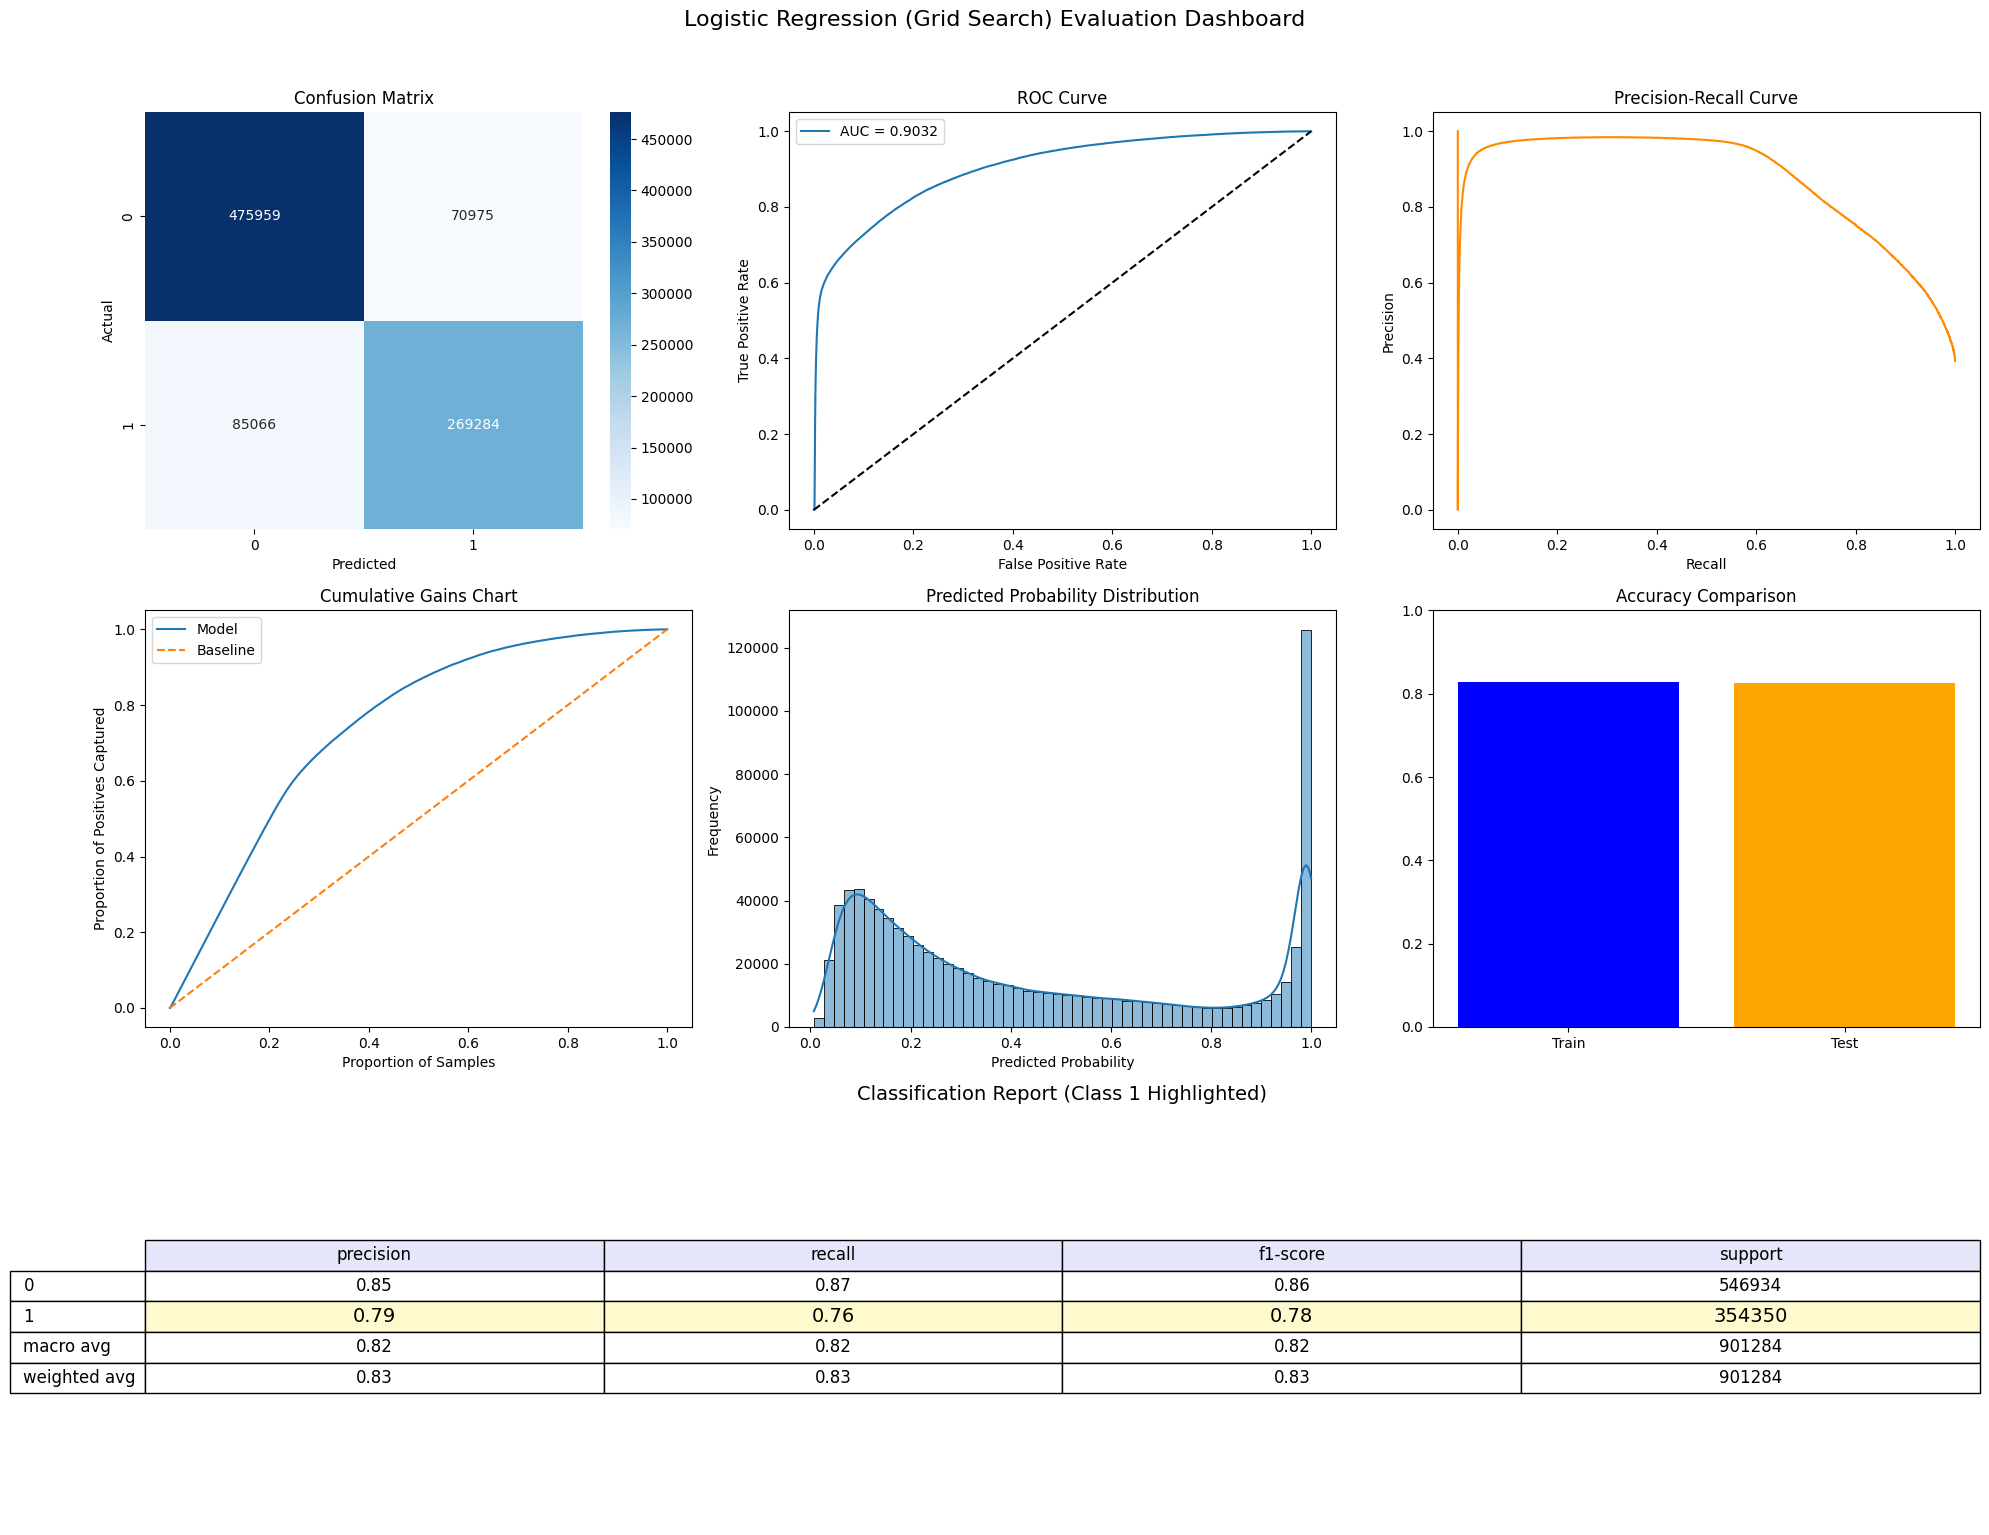


Logistic Regression (Grid Search) Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86    546934
           1       0.79      0.76      0.78    354350

    accuracy                           0.83    901284
   macro avg       0.82      0.82      0.82    901284
weighted avg       0.83      0.83      0.83    901284

Logistic Regression (Grid Search) ROC AUC Score: 0.9032
Logistic Regression (Grid Search) Train Accuracy: 0.8271
Logistic Regression (Grid Search) Test Accuracy:  0.8269
No overfitting: Training and test accuracies are close.


In [17]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2'], # l1, elasticnet, none are also options depending on solver
    'solver': ['liblinear', 'lbfgs'], # solvers that support l2
    'class_weight': [None, 'balanced'] # Option to balance class weights
}

# Create a Logistic Regression model instance
logreg = LogisticRegression(max_iter=1000, random_state=42)


# Create the GridSearchCV object
# We use roc_auc as the scoring metric because it's often more informative than accuracy
# for imbalanced datasets.
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Fit the grid search to the training data
print("Performing Grid Search...")
grid_search.fit(X_train_scaled, y_train) # Use scaled data for Logistic Regression

# Get the best parameters and the best score
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC AUC score: {:.4f}".format(grid_search.best_score_))

# Get the best model
best_logreg_model = grid_search.best_estimator_

# Evaluate the best model on the test set
print("\nEvaluating best Logistic Regression model on test set:")
evaluate_model(best_logreg_model, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Logistic Regression (Grid Search)")


In [18]:
best_logreg_model.get_params()

{'C': 0.001,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### 5.1.2 XGBoost

In [19]:
# Train XGBoost model without DMatrix
xgb_model = xgb.XGBClassifier(objective='binary:logistic',  # For binary classification
                              eval_metric='logloss',       # Evaluation metric
                              n_estimators=100,            # Number of boosting rounds
                              learning_rate=0.1,           # Step size shrinkage
                              max_depth=10,                 # Maximum depth of a tree
                              random_state=42,             # For reproducibility
                              n_jobs=-1                    # Use all available cores
                             )

xgb_model.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [20]:
xgb_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'logloss',
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

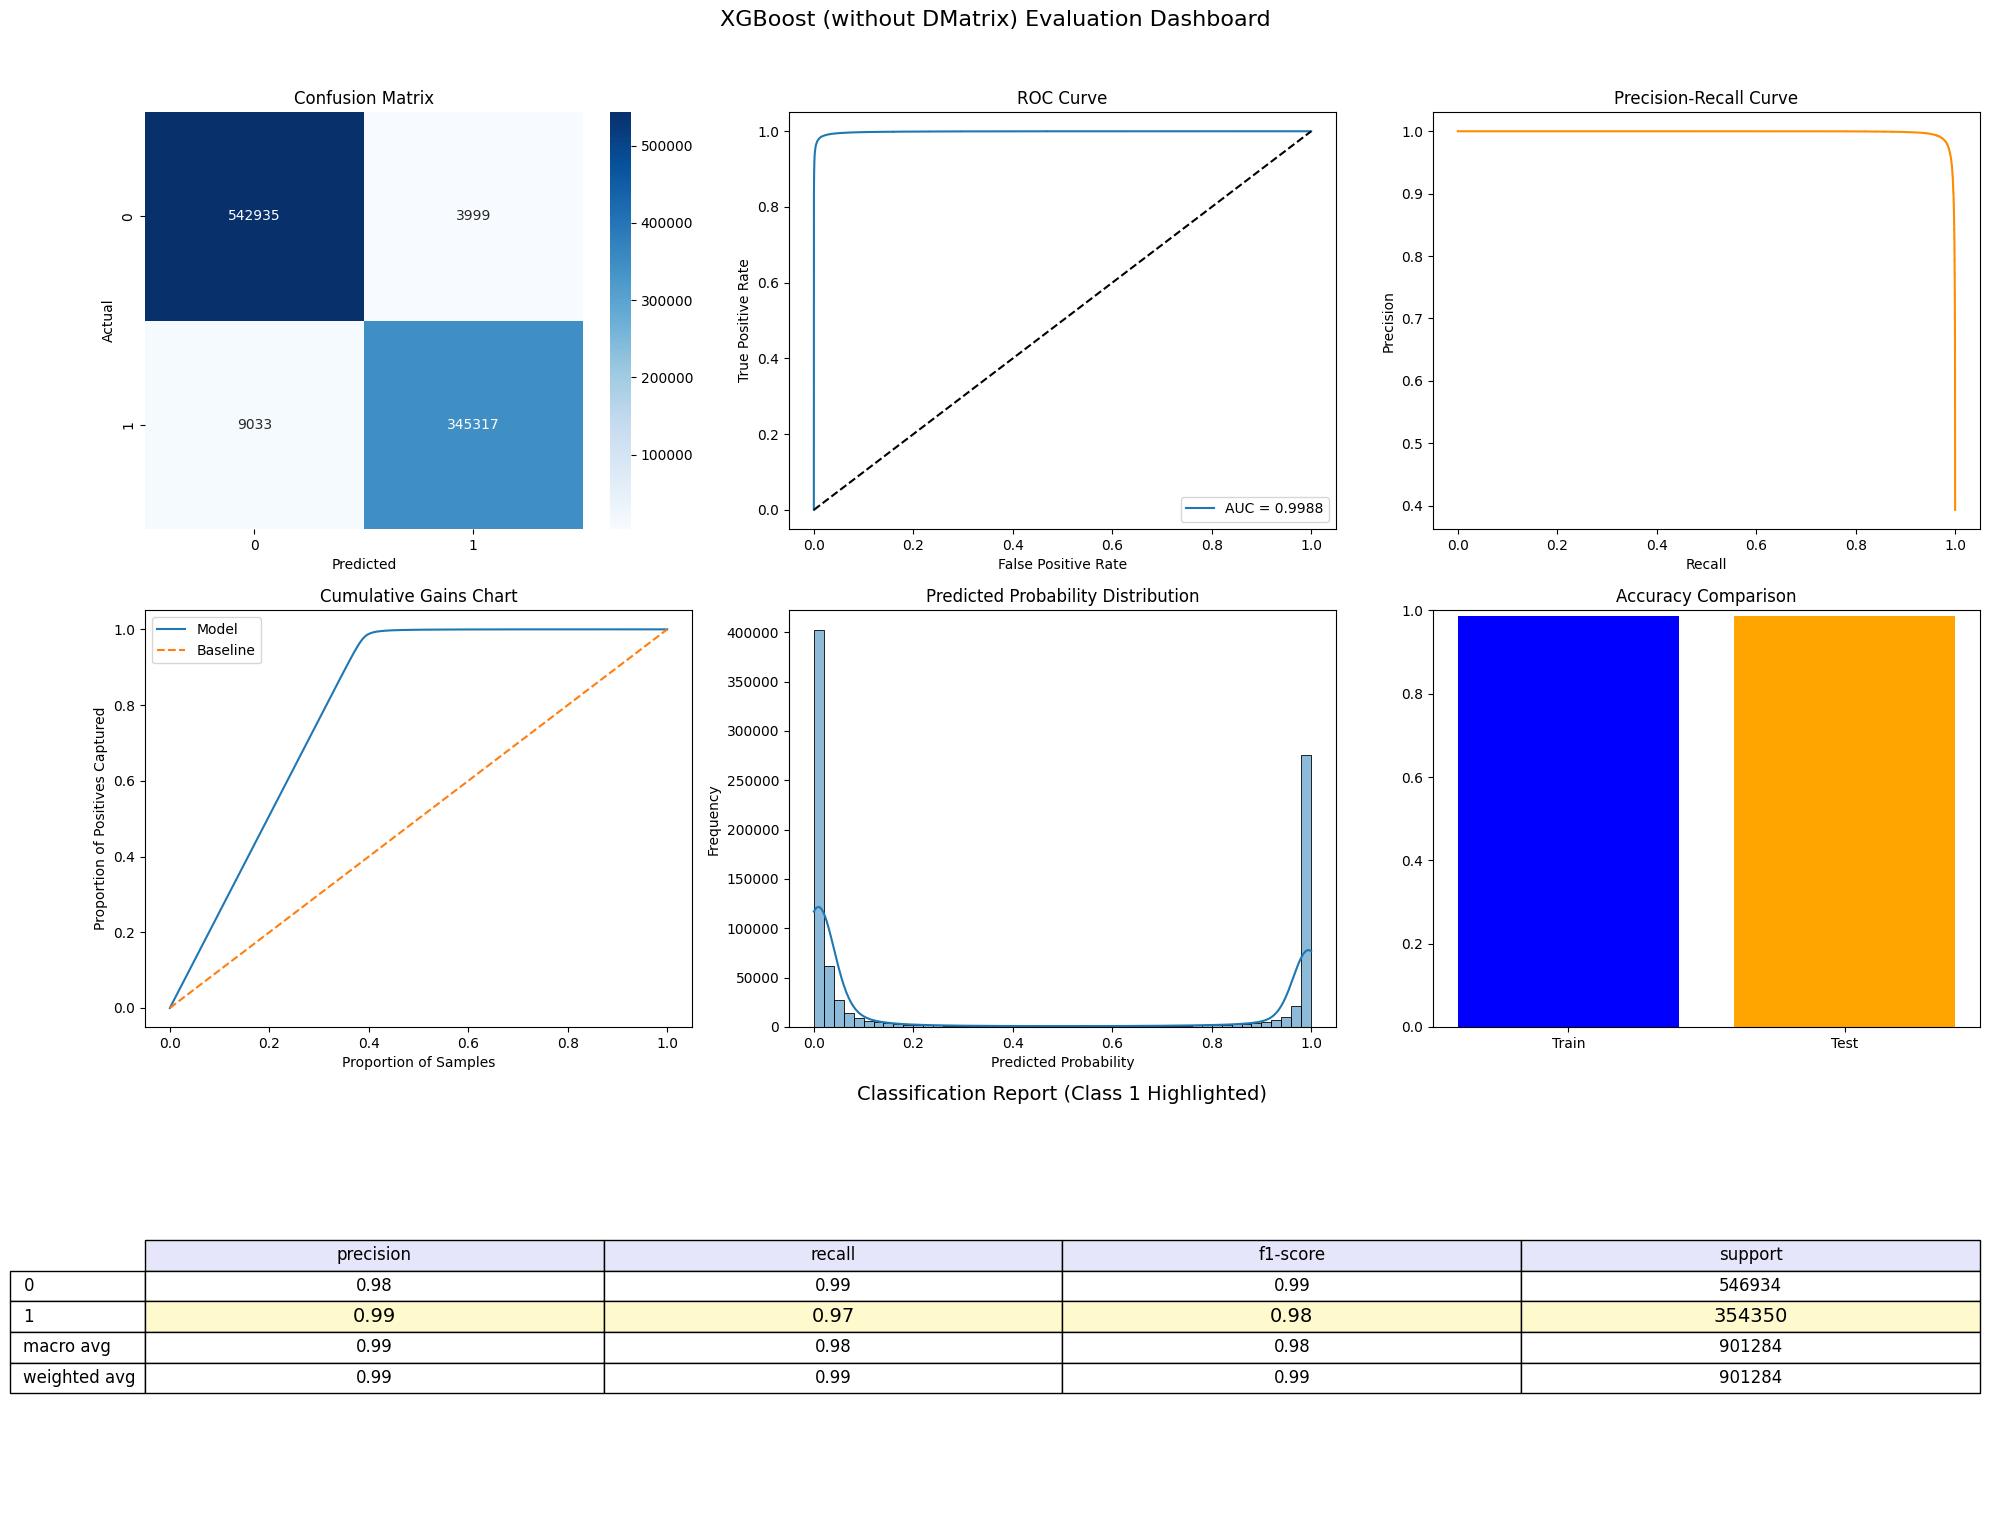


XGBoost (without DMatrix) Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    546934
           1       0.99      0.97      0.98    354350

    accuracy                           0.99    901284
   macro avg       0.99      0.98      0.98    901284
weighted avg       0.99      0.99      0.99    901284

XGBoost (without DMatrix) ROC AUC Score: 0.9988
XGBoost (without DMatrix) Train Accuracy: 0.9864
XGBoost (without DMatrix) Test Accuracy:  0.9855
No overfitting: Training and test accuracies are close.


In [21]:
# Evaluate the model
evaluate_model(xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, model_name="XGBoost (without DMatrix)")

## **5.2 Deep Learning**

### Deep Preprocessing

In [22]:
# Feature Engineering (as provided)
X_original_features = df.drop(columns=['is_fraud', 'cc_num', 'trans_date_trans_time'], axis=1, errors='ignore')
y_target_for_encoding = df['is_fraud']

num_cols = ['amt', 'city_pop', 'age', 'trans_year']
high_card_cols = ['merchant', 'category', 'job_category','state','city']
low_card_cols = ['Region', 'day_period', 'age_group', 'trans_month', 'day_name']
ready_cols = ['gender', 'is_weekend']

existing_num_cols = [col for col in num_cols if col in X_original_features.columns]
existing_high_card_cols = [col for col in high_card_cols if col in X_original_features.columns]
existing_low_card_cols = [col for col in low_card_cols if col in X_original_features.columns]
existing_ready_cols = [col for col in ready_cols if col in X_original_features.columns]

if existing_high_card_cols:
    encoder = TargetEncoder(cols=existing_high_card_cols)
    X_high = encoder.fit_transform(X_original_features[existing_high_card_cols], y_target_for_encoding)
else: X_high = pd.DataFrame(index=X_original_features.index)
if existing_low_card_cols:
    X_low = pd.get_dummies(X_original_features[existing_low_card_cols], columns=existing_low_card_cols, drop_first=True)
else: X_low = pd.DataFrame(index=X_original_features.index)
if existing_num_cols:
    scaler_feat_eng = StandardScaler()
    X_num = pd.DataFrame(scaler_feat_eng.fit_transform(X_original_features[existing_num_cols]), columns=existing_num_cols, index=X_original_features.index)
else: X_num = pd.DataFrame(index=X_original_features.index)
if existing_ready_cols:
    X_ready = X_original_features[existing_ready_cols].copy()
else: X_ready = pd.DataFrame(index=X_original_features.index)

X_processed = pd.concat([X_num, X_high, X_low, X_ready], axis=1)

In [23]:
# --- Step 1: Create sequences ---
df_for_sequencing = X_processed.copy()
df_for_sequencing['cc_num'] = df['cc_num']
df_for_sequencing['trans_date_trans_time'] = df['trans_date_trans_time']
df_for_sequencing['is_fraud'] = df['is_fraud']

sequence_length = 5
df_for_sequencing = df_for_sequencing.sort_values(['cc_num', 'trans_date_trans_time'])
sequences = []
labels = []
feature_columns_for_sequence = X_processed.columns.tolist()

for _, group in df_for_sequencing.groupby('cc_num'):
    if len(group) <= sequence_length:
        continue
    X_customer_features = group[feature_columns_for_sequence].values
    y_customer_labels = group['is_fraud'].values
    for i in range(sequence_length, len(group)):
        sequences.append(X_customer_features[i-sequence_length:i])
        labels.append(y_customer_labels[i])

if not sequences:
    print("No sequences were generated. Cannot proceed.")
    exit()
else:
    X_final_sequences = np.array(sequences)
    y_final_labels = np.array(labels)
    print(f"Shape of X_final_sequences: {X_final_sequences.shape}")
    print(f"Shape of y_final_labels: {y_final_labels.shape}")

Shape of X_final_sequences: (2999317, 5, 38)
Shape of y_final_labels: (2999317,)


In [24]:
# --- Step 2: Prepare Data ---
if len(np.unique(y_final_labels)) > 1:
    X_train_seq, X_test_seq, y_train_seq_labels, y_test_seq_labels = train_test_split(
        X_final_sequences, y_final_labels, test_size=0.3, random_state=42, stratify=y_final_labels
    )
else:
    X_train_seq, X_test_seq, y_train_seq_labels, y_test_seq_labels = train_test_split(
        X_final_sequences, y_final_labels, test_size=0.3, random_state=42
    )

print(f"\nData Split:")
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq_labels shape: {y_train_seq_labels.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq_labels shape: {y_test_seq_labels.shape}")

# Filter out normal sequences from the training set for training the autoencoder
X_train_seq_normal = X_train_seq[y_train_seq_labels == 0]
print(f"X_train_seq_normal (for AE training) shape: {X_train_seq_normal.shape}")

if X_train_seq_normal.shape[0] == 0:
    print("No normal sequences in the training set to train the autoencoder. Stopping.")
    exit()

set_seed(42)


Data Split:
X_train_seq shape: (2099521, 5, 38), y_train_seq_labels shape: (2099521,)
X_test_seq shape: (899796, 5, 38), y_test_seq_labels shape: (899796,)
X_train_seq_normal (for AE training) shape: (1273011, 5, 38)


### 5.2.1 DNN

In [25]:
set_seed(42)
# Step 1: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Build DNN model
model_dnn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-20 23:45:18.089989: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Step 3: Compile the model
model_dnn.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 4: Fit the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_dnn = model_dnn.fit(X_train_scaled, y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/10


3286/3286 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9116 - loss: 0.2152 - val_accuracy: 0.9717 - val_loss: 0.0793
Epoch 2/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9691 - loss: 0.0849 - val_accuracy: 0.9813 - val_loss: 0.0535
Epoch 3/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9777 - loss: 0.0622 - val_accuracy: 0.9854 - val_loss: 0.0426
Epoch 4/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9814 - loss: 0.0519 - val_accuracy: 0.9872 - val_loss: 0.0375
Epoch 5/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9841 - loss: 0.0455 - val_accuracy: 0.9882 - val_loss: 0.0349
Epoch 6/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9859 - loss: 0.0411 - val_accuracy: 0.9892 - val_loss: 0.0319
Epoch 7/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9868 - loss: 0.0381 - val_accuracy: 0.9902 - val_loss: 0.0291
Epoch 8/10
3286/3286 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9877 - loss: 0.0354 - val_accura

  301/28166 ━━━━━━━━━━━━━━━━━━━━ 13s 502us/step

28166/28166 ━━━━━━━━━━━━━━━━━━━━ 14s 494us/step
65719/65719 ━━━━━━━━━━━━━━━━━━━━ 33s 502us/step


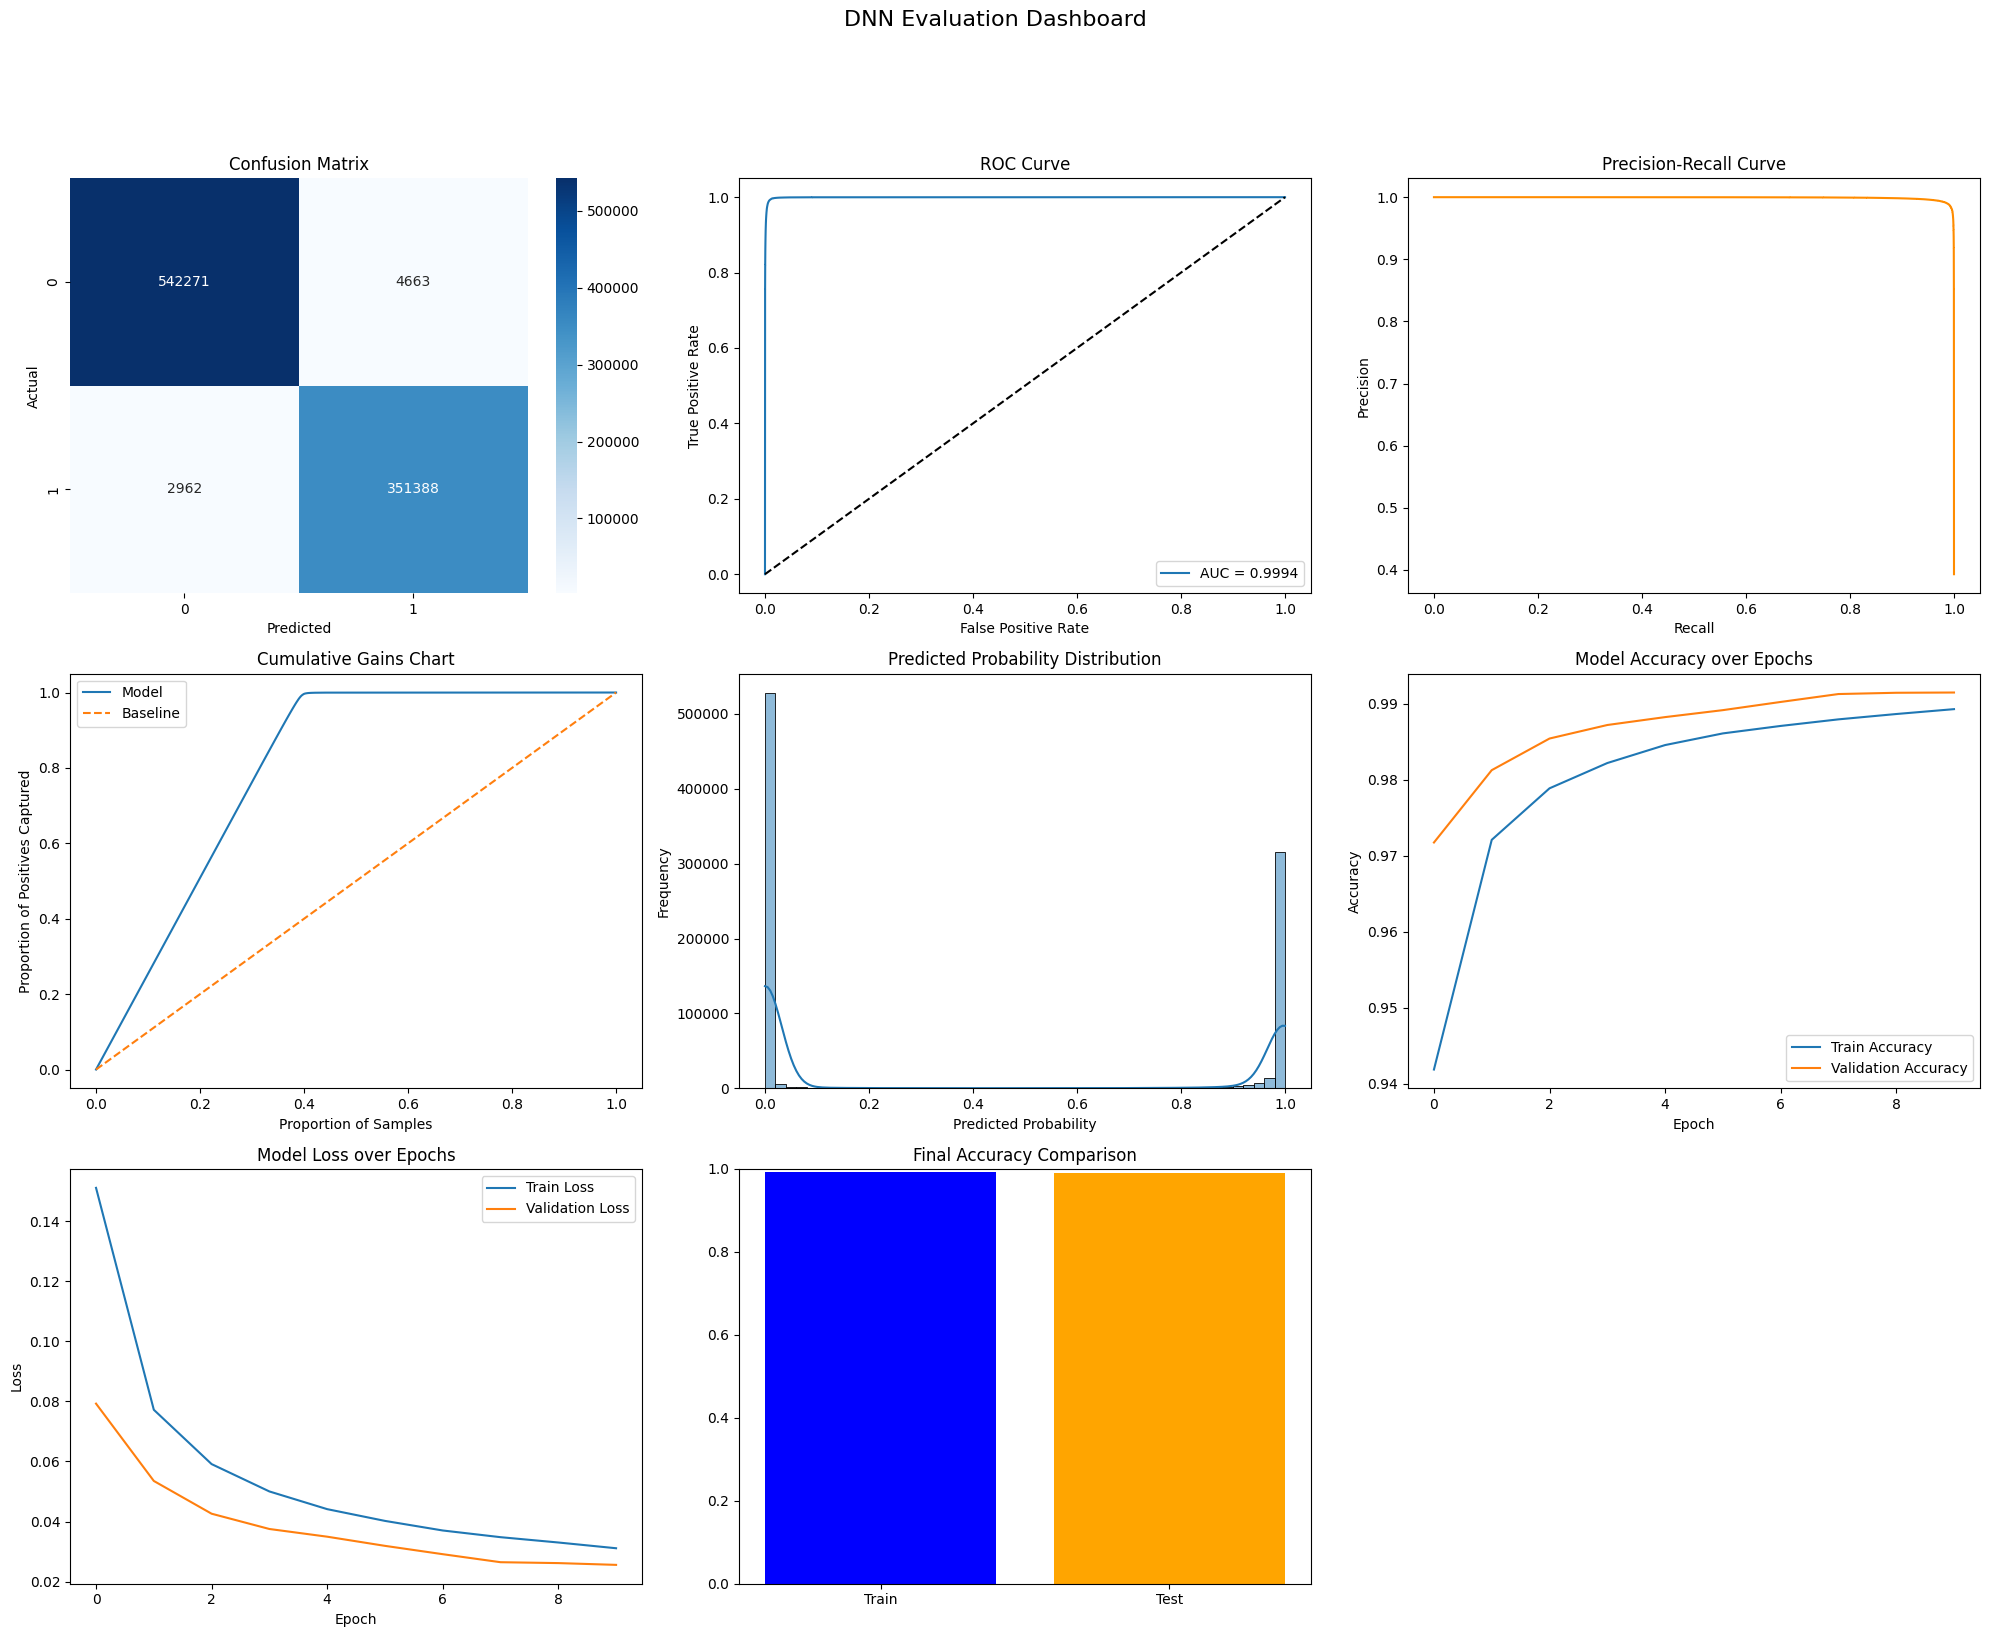


DNN Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    546934
           1       0.99      0.99      0.99    354350

    accuracy                           0.99    901284
   macro avg       0.99      0.99      0.99    901284
weighted avg       0.99      0.99      0.99    901284

DNN ROC AUC Score: 0.9994
Final Train Accuracy: 0.9921
Final Test Accuracy:  0.9915
No significant overfitting/underfitting detected.


In [28]:
evaluate_nn_model(model_dnn, X_train_scaled, y_train, X_test_scaled, y_test, model_name="DNN", history=history_dnn)

### 5.2.2 LSTM

In [29]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Ensure data types are correct ---
X_final_sequences = X_final_sequences.astype('float32')
y_final_labels = y_final_labels.astype('int32')


print(f"Shape of X_final_sequences: {X_final_sequences.shape}")
print(f"Shape of y_final_labels: {y_final_labels.shape}")
print(f"\nCorrected Dtype of X_final_sequences: {X_final_sequences.dtype}")
print(f"Corrected Dtype of y_final_labels: {y_final_labels.dtype}")


# --- Step 2: Prepare Data (Now with corrected dtypes) ---
# This block now ONLY handles the data splitting.
if len(np.unique(y_final_labels)) > 1:
    # This branch is taken if you have both 0s and 1s in your labels
    print("\nPerforming stratified split...")
    X_train_seq, X_test_seq, y_train_seq_labels, y_test_seq_labels = train_test_split(
        X_final_sequences, y_final_labels, test_size=0.3, random_state=42, stratify=y_final_labels
    )
else:
    # This branch is taken if all your labels are the same (e.g., all 0s)
    print("\nPerforming non-stratified split (only one class present)...")
    X_train_seq, X_test_seq, y_train_seq_labels, y_test_seq_labels = train_test_split(
        X_final_sequences, y_final_labels, test_size=0.3, random_state=42
    )

print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq_labels shape: {y_train_seq_labels.shape}")


# --- Step 3: Define and Compile the Model ---
# This code is now OUTSIDE the if/else block, so it will always run.
print("\nDefining and compiling the LSTM model...")
model_lstm = Sequential([
    LSTM(128, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), return_sequences=True),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_lstm.summary()


# --- Step 4: Train the Model ---
# This code will also now always run correctly.
print("\nTraining the model...")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq_labels,
    validation_split=0.2,
    epochs=20,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)


Shape of X_final_sequences: (2999317, 5, 38)
Shape of y_final_labels: (2999317,)

Corrected Dtype of X_final_sequences: float32
Corrected Dtype of y_final_labels: int32

Performing stratified split...


X_train_seq shape: (2099521, 5, 38), y_train_seq_labels shape: (2099521,)

Defining and compiling the LSTM model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        85,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,025 (535.25 KB)

 Trainable params: 137,025 (535.25 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 53s 16ms/step - accuracy: 0.9688 - loss: 0.0887 - val_accuracy: 0.9938 - val_loss: 0.0230
Epoch 2/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9934 - loss: 0.0237 - val_accuracy: 0.9946 - val_loss: 0.0199
Epoch 3/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9951 - loss: 0.0187 - val_accuracy: 0.9956 - val_loss: 0.0168
Epoch 4/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.9963 - loss: 0.0151 - val_accuracy: 0.9968 - val_loss: 0.0132
Epoch 5/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.9969 - loss: 0.0132 - val_accuracy: 0.9971 - val_loss: 0.0121
Epoch 6/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 16ms/step - accuracy: 0.9973 - loss: 0.0119 - val_accuracy: 0.9973 - val_loss: 0.0116
Epoch 7/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accuracy: 0.9975 - loss: 0.0110 - val_accuracy: 0.9974 - val_loss: 0.0112
Epoch 8/20
3281/3281 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/st

--- Evaluating Fraud Detection LSTM ---
 4002/28119 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step

28119/28119 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step
65611/65611 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step

Fraud Detection LSTM Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    545577
           1       1.00      1.00      1.00    354219

    accuracy                           1.00    899796
   macro avg       1.00      1.00      1.00    899796
weighted avg       1.00      1.00      1.00    899796



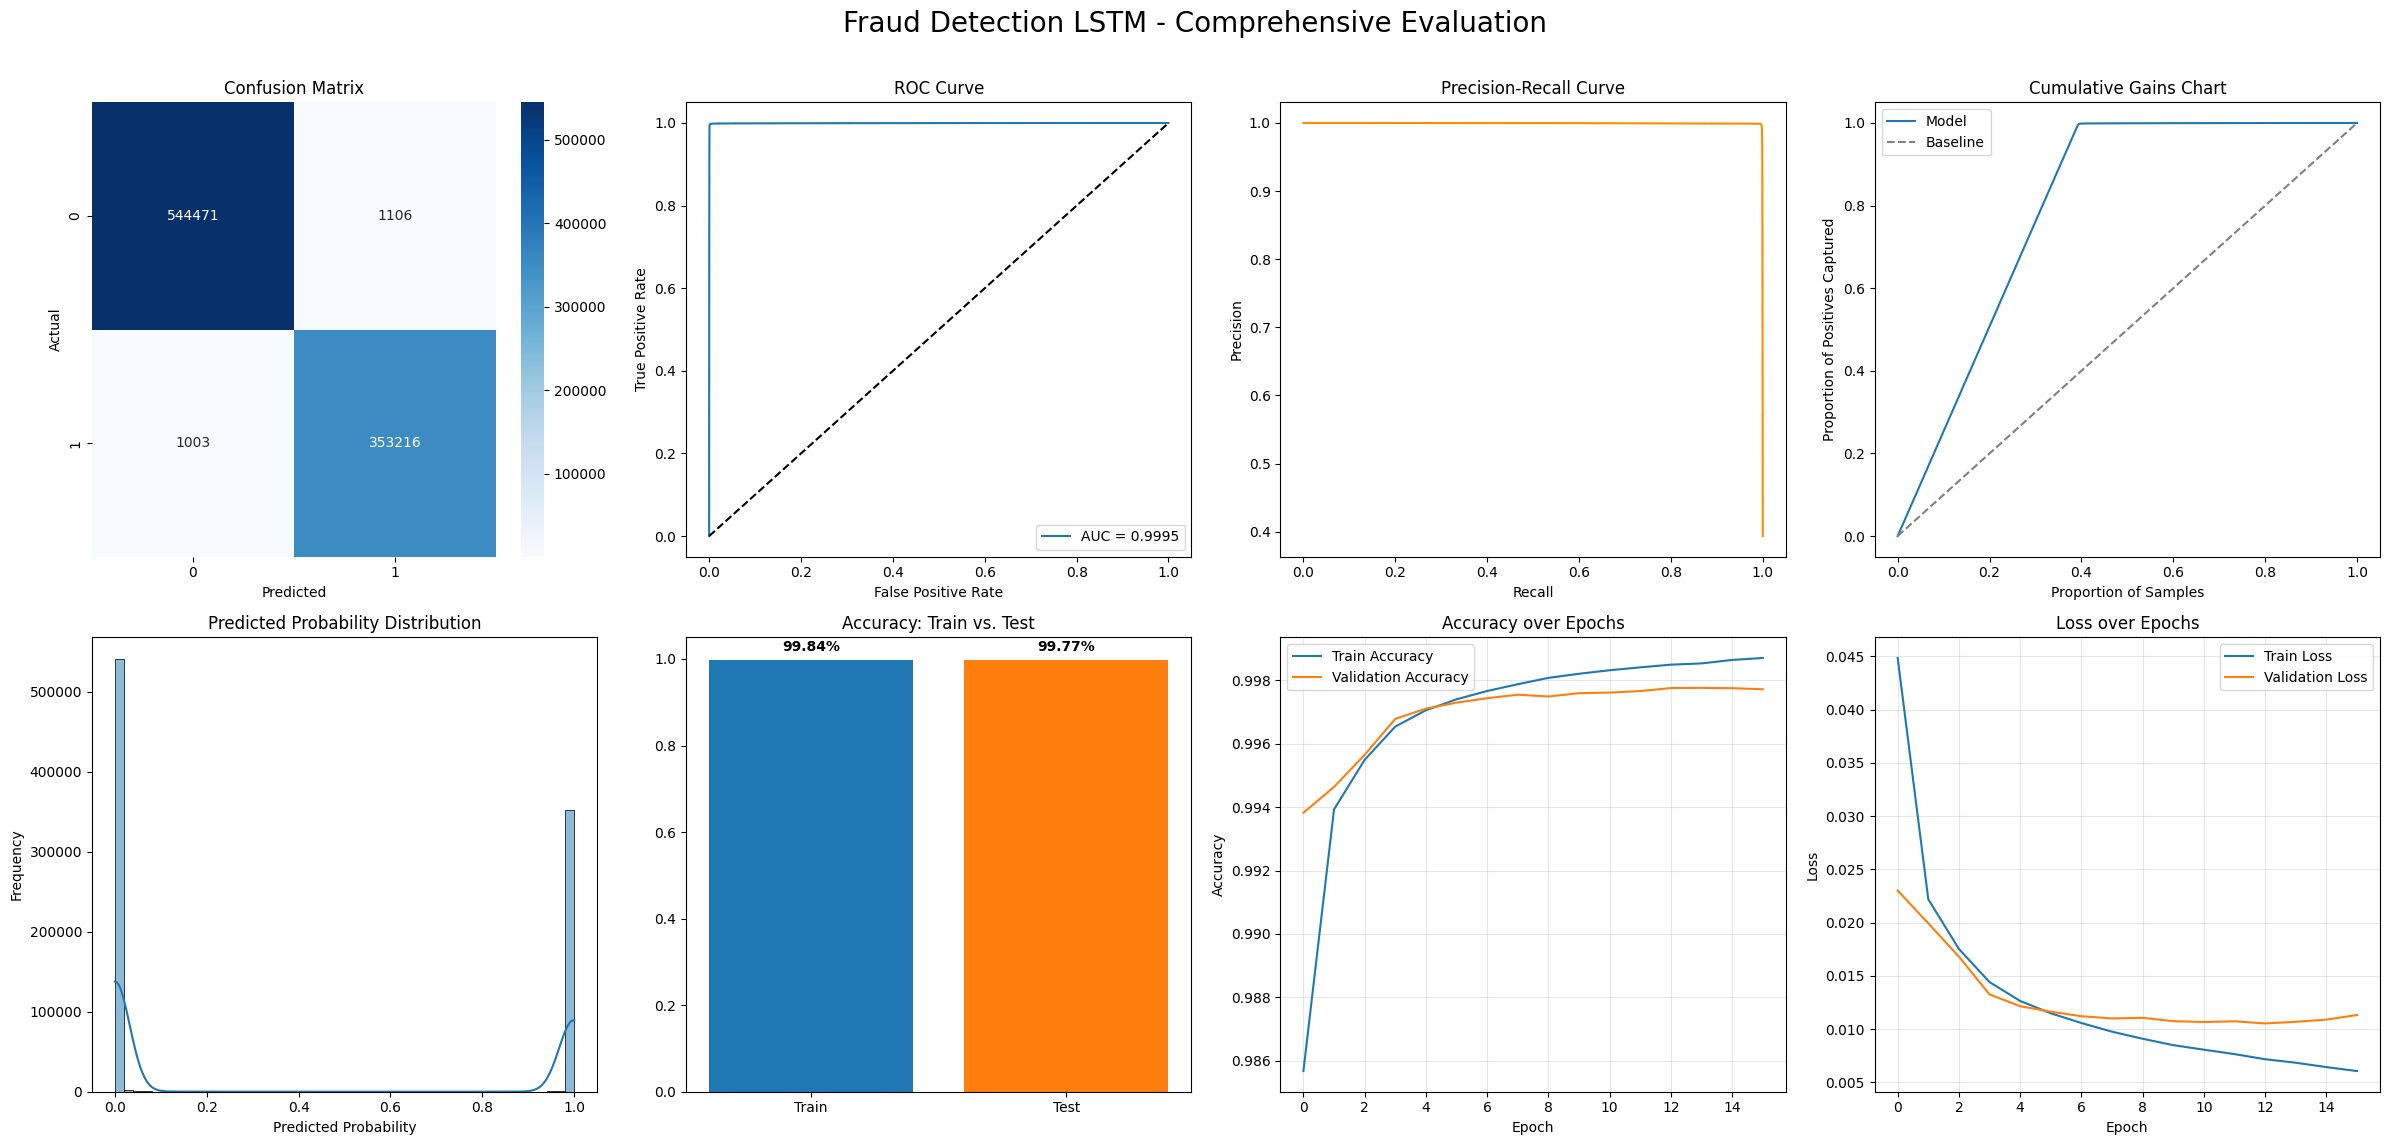


Fraud Detection LSTM Final Metrics:
-> ROC AUC Score: 0.9995
-> Train Accuracy: 0.9984
-> Test Accuracy:  0.9977
-> Good Generalization: Training and test accuracies are close.


In [30]:
evaluate_sequences_model(
    model=model_lstm,
    X_train_seq=X_train_seq,
    y_train_labels=y_train_seq_labels,
    X_test_seq=X_test_seq,
    y_test_labels=y_test_seq_labels,
    history=history_lstm,
    model_name="Fraud Detection LSTM"
)

### 5.2.3 RNN

In [ ]:
set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Reshape X_train to 3D array for RNN input
X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the RNN model
rnn_model = Sequential([
    SimpleRNN(128, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True),

    SimpleRNN(64, return_sequences=False),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
rnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
rnn_model.summary()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_RNN_pred_prob = rnn_model.predict(X_test)
y_pred_rnn = (y_RNN_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_rnn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rnn))
print("Classification Report:\n", classification_report(y_test, y_pred_rnn))


### 5.2.4 Autoencoder

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

In [32]:
X_train_seq_normal = X_train_seq[y_train_seq_labels == 0]

print(f"Original shape of normal training sequences: {X_train_seq_normal.shape}")
print(f"Original shape of test sequences: {X_test_seq.shape}")

# --- Step 2: Flatten the Sequence Data ---
# This is the key step to make the data compatible with Dense layers.
# We reshape from (samples, timesteps, features) to (samples, timesteps * features).
n_samples, n_timesteps, n_features = X_train_seq_normal.shape
X_train_normal_flat = X_train_seq_normal.reshape((n_samples, n_timesteps * n_features))

n_samples_test, _, _ = X_test_seq.shape
X_test_flat = X_test_seq.reshape((n_samples_test, n_timesteps * n_features))

input_dim = X_train_normal_flat.shape[1] # The new input dimension is timesteps * features

Original shape of normal training sequences: (1273011, 5, 38)
Original shape of test sequences: (899796, 5, 38)


In [34]:
# --- Step 3: Define the Dense Autoencoder (Your Original Architecture) ---
encoding_dim = 128  # This can be tuned

autoencoder_dense = Sequential([
    Dense(encoding_dim * 2, input_shape=(input_dim,)),
    LeakyReLU(alpha=0.1),
    Dropout(0.1),
    Dense(encoding_dim),
    LeakyReLU(alpha=0.1),
    Dense(encoding_dim * 2),
    LeakyReLU(alpha=0.1),
    Dense(input_dim, activation='linear') # Reconstruct the flattened vector
])

# Compile the Autoencoder
# We monitor 'mse' (mean squared error) as the loss. 'accuracy' is not applicable here.
autoencoder_dense.compile(optimizer='adam', loss='mse')
autoencoder_dense.summary()

# --- Step 4: Train the Autoencoder on Flattened Normal Data ---
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_ae_dense = autoencoder_dense.fit(
    X_train_normal_flat, X_train_normal_flat, # Train on flattened normal data
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1 # verbose=1 will print the loss for each epoch during training
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 256)            │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 190)            │        48,830 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,646 (639.24 KB)

 Trainable params: 163,646 (639.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - loss: 0.0111 - val_loss: 0.0015
Epoch 2/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0025 - val_loss: 8.1221e-04
Epoch 3/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0015 - val_loss: 6.1626e-04
Epoch 4/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0012 - val_loss: 5.2385e-04
Epoch 5/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0010 - val_loss: 4.7717e-04
Epoch 6/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 0.0010 - val_loss: 4.3052e-04
Epoch 7/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - loss: 0.0010 - val_loss: 4.9231e-04
Epoch 8/50
31826/31826 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 9.8412e-04 - val_loss: 4.8848e-04


In [35]:
# --- Step 6: Calculate Reconstruction Errors ---
# Define MSE loss with no reduction (element-wise)
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

# CORRECTED FUNCTION
def get_reconstruction_errors(true_data, pred_data):
    """
    Calculates reconstruction errors.
    mse_fn with reduction=NONE already returns the per-sample error.
    """
    errors = mse_fn(true_data, pred_data).numpy()
    # No need for .mean(axis=1) as 'errors' is already a 1D array of per-sample errors
    return errors


In [36]:
# Calculate reconstruction errors on the flattened test set
reconstructions = autoencoder_dense.predict(X_test_flat)
reconstruction_errors = get_reconstruction_errors(X_test_flat, reconstructions)

28119/28119 ━━━━━━━━━━━━━━━━━━━━ 16s 580us/step


In [37]:
# --- Step 7: Find an Optimal Threshold and Evaluate ---
# Use Precision-Recall curve to find a good threshold
prec, rec, thresholds = precision_recall_curve(y_test_seq_labels, reconstruction_errors)

# Find the threshold that gives the best F1-score
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9) # Add epsilon for stability
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nDense Autoencoder Best Threshold (max F1-score): {best_threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae_dense = (reconstruction_errors > best_threshold).astype(int)

# Evaluate performance
print("\nDense Autoencoder on Flattened Sequences - Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test_seq_labels, y_pred_ae_dense))
print("\nClassification Report:")
print(classification_report(y_test_seq_labels, y_pred_ae_dense))
print(f"\nROC AUC Score: {roc_auc_score(y_test_seq_labels, reconstruction_errors):.4f}")


Dense Autoencoder Best Threshold (max F1-score): 0.0006

Dense Autoencoder on Flattened Sequences - Evaluation:
Confusion Matrix:
[[476240  69337]
 [ 49322 304897]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    545577
           1       0.81      0.86      0.84    354219

    accuracy                           0.87    899796
   macro avg       0.86      0.87      0.86    899796
weighted avg       0.87      0.87      0.87    899796


ROC AUC Score: 0.9338


--- Evaluating AutoEncoder ---
  268/28119 ━━━━━━━━━━━━━━━━━━━━ 15s 564us/step

28119/28119 ━━━━━━━━━━━━━━━━━━━━ 16s 581us/step

AutoEncoder Classification Report (Threshold: 0.0006):

              precision    recall  f1-score   support

           0       0.91      0.87      0.89    545577
           1       0.81      0.86      0.84    354219

    accuracy                           0.87    899796
   macro avg       0.86      0.87      0.86    899796
weighted avg       0.87      0.87      0.87    899796



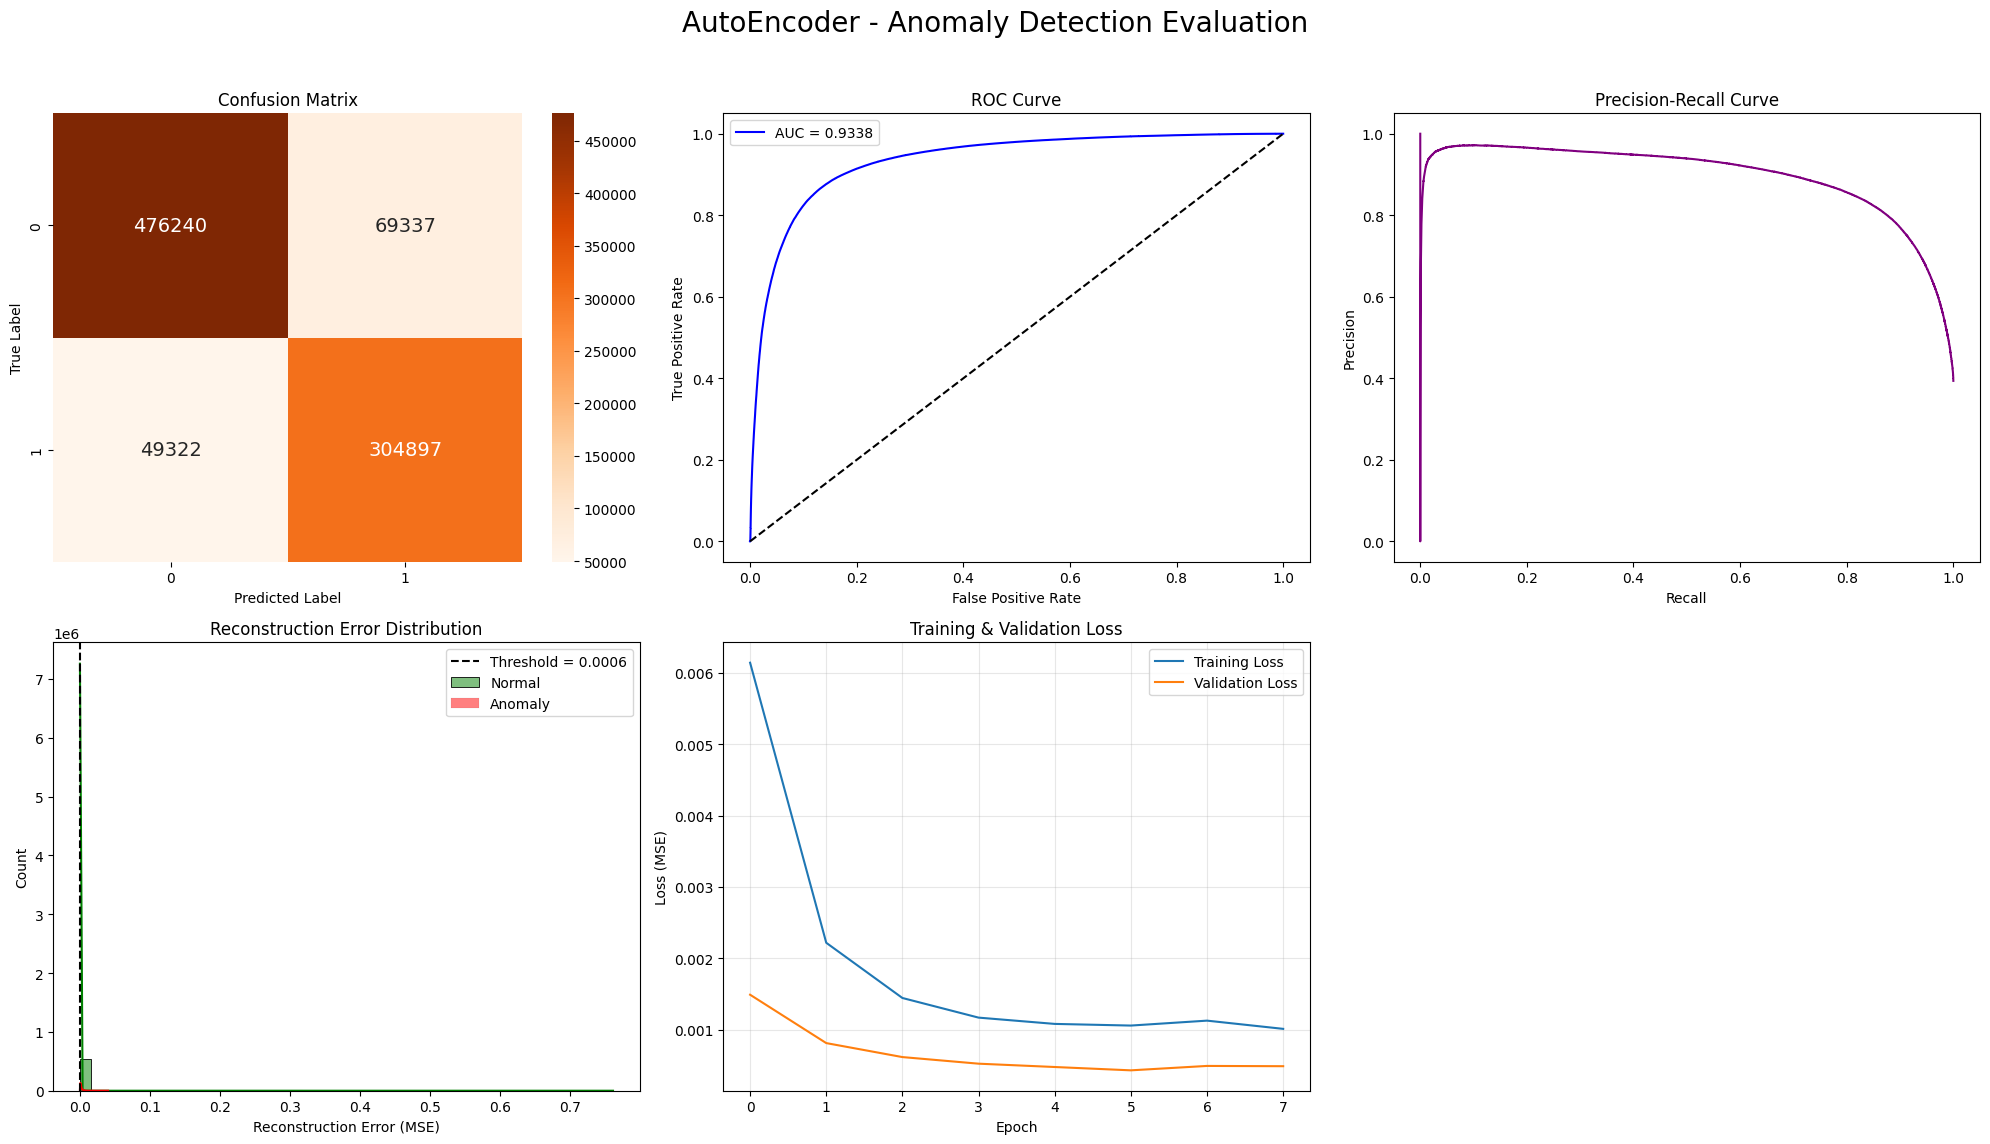


AutoEncoder Final Metrics:
-> ROC AUC Score: 0.9338


In [38]:
evaluate_autoencoder_model(
    model=autoencoder_dense,
    X_test_flat=X_test_flat,
    y_test_labels=y_test_seq_labels,
    threshold=best_threshold,
    history=history_ae_dense,
    model_name="AutoEncoder"
)

### **AE + LR**

In [39]:
# --- This code assumes the previous autoencoder script has been run ---
# 'autoencoder_dense' is the trained model.
# 'X_train_seq' and 'X_test_seq' are the original 3D sequence data.

print("--- Step 1: Calculating Reconstruction Errors for Train and Test Sets ---")

# Flatten the ENTIRE training sequence data (not just the normal part)
n_samples_train, n_timesteps_train, n_features_train = X_train_seq.shape
X_train_flat = X_train_seq.reshape((n_samples_train, n_timesteps_train * n_features_train))

# Predict reconstructions for the training set
train_reconstructions = autoencoder_dense.predict(X_train_flat)

# Calculate reconstruction errors for the training set
train_reconstruction_errors = get_reconstruction_errors(X_train_flat, train_reconstructions)

# The test set errors are already calculated from your previous code
test_reconstruction_errors = reconstruction_errors 

print(f"Shape of training errors: {train_reconstruction_errors.shape}")
print(f"Shape of testing errors: {test_reconstruction_errors.shape}")

--- Step 1: Calculating Reconstruction Errors for Train and Test Sets ---
 2217/65611 ━━━━━━━━━━━━━━━━━━━━ 35s 567us/step

65611/65611 ━━━━━━━━━━━━━━━━━━━━ 38s 573us/step
Shape of training errors: (2099521,)
Shape of testing errors: (899796,)


In [40]:
# Reshape errors to be a 2D array with one column
train_errors_reshaped = train_reconstruction_errors.reshape(-1, 1)
test_errors_reshaped = test_reconstruction_errors.reshape(-1, 1)

print(f"\nReshaped training errors for scikit-learn: {train_errors_reshaped.shape}")
print(f"Reshaped testing errors for scikit-learn: {test_errors_reshaped.shape}")


Reshaped training errors for scikit-learn: (2099521, 1)
Reshaped testing errors for scikit-learn: (899796, 1)


In [41]:
from sklearn.preprocessing import StandardScaler

# 1. Create the enhanced feature sets by adding the error as a new column
# We use np.c_ for concise column-wise concatenation
X_train_enhanced = np.c_[X_train_flat, train_reconstruction_errors]
X_test_enhanced = np.c_[X_test_flat, test_reconstruction_errors]

print(f"Shape of enhanced training set: {X_train_enhanced.shape}")
print(f"Shape of enhanced test set: {X_test_enhanced.shape}")

# 2. Scale the new combined dataset
# It's important to scale AFTER adding the new feature
scaler_enhanced = StandardScaler()
X_train_enhanced_scaled = scaler_enhanced.fit_transform(X_train_enhanced)
X_test_enhanced_scaled = scaler_enhanced.transform(X_test_enhanced)

# 3. Initialize and train the new Logistic Regression model
lr_model_enhanced = LogisticRegression(random_state=42, max_iter=1000)
lr_model_enhanced.fit(X_train_enhanced_scaled, y_train_seq_labels)

# 4. Make predictions and evaluate
y_pred_lr_enhanced = lr_model_enhanced.predict(X_test_enhanced_scaled)

print("\nClassification Report (Enhanced Feature Set):")
print(classification_report(y_test_seq_labels, y_pred_lr_enhanced))

Shape of enhanced training set: (2099521, 191)
Shape of enhanced test set: (899796, 191)



Classification Report (Enhanced Feature Set):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94    545577
           1       0.94      0.87      0.91    354219

    accuracy                           0.93    899796
   macro avg       0.93      0.92      0.92    899796
weighted avg       0.93      0.93      0.93    899796



#### 5.2.4.1 Autoencoder with ADAM

In [ ]:
#ADAM

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Filter out the normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]

# Scale the normal transactions
scaler_ae = StandardScaler()
X_train_normal_scaled = scaler_ae.fit_transform(X_train_normal)

# Define the Autoencoder model
input_dim = X_train_normal_scaled.shape[1]
encoding_dim = 14  # adjust this based on experimentation

autoencoder = Sequential([
    # Encoder
    Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu'),
    # Decoder
    Dense(encoding_dim * 2, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer with linear activation for reconstruction
])

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Autoencoder on normal transactions
history_ae = autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Scale the entire test set
X_test_scaled_ae = scaler_ae.transform(X_test)

# Define MSE loss with no reduction (element-wise)
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

# Get reconstruction errors function, handling shape properly
def get_reconstruction_errors(true_data, pred_data):
    errors = mse_fn(true_data, pred_data).numpy()
    if errors.ndim > 1:
        # Average over features dimension (axis=1)
        return errors.mean(axis=1)
    else:
        # Already 1D, just return as is
        return errors

# Calculate reconstruction errors on test set
reconstructions = autoencoder.predict(X_test_scaled_ae)
reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, reconstructions)

# Calculate reconstruction errors on training normal set (for threshold)
train_reconstructions = autoencoder.predict(X_train_normal_scaled)
train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

# Choose threshold based on percentile of training errors (e.g., 95th percentile)
threshold = np.percentile(train_reconstruction_errors, 95)

print(f"\nAutoencoder Reconstruction Error Threshold: {threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate performance
print("\nAutoencoder Anomaly Detection Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, reconstruction_errors))  # Use raw errors for ROC AUC


#### 5.2.4.2 Autoencoder with SGD

In [ ]:
# sgd

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Filter out the normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]

# Scale the normal transactions
scaler_ae = StandardScaler()
X_train_normal_scaled = scaler_ae.fit_transform(X_train_normal)

# Define the Autoencoder model
input_dim = X_train_normal_scaled.shape[1]
encoding_dim = 14  # adjust this based on experimentation

autoencoder = Sequential([
    # Encoder
    Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu'),
    # Decoder
    Dense(encoding_dim * 2, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer with linear activation for reconstruction
])

# Compile the Autoencoder
autoencoder.compile(optimizer='sgd', loss='mse')

# Early stopping callback
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Autoencoder on normal transactions
history_ae = autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Scale the entire test set
X_test_scaled_ae = scaler_ae.transform(X_test)

# Define MSE loss with no reduction (element-wise)
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

# Get reconstruction errors function, handling shape properly
def get_reconstruction_errors(true_data, pred_data):
    errors = mse_fn(true_data, pred_data).numpy()
    if errors.ndim > 1:
        # Average over features dimension (axis=1)
        return errors.mean(axis=1)
    else:
        # Already 1D, just return as is
        return errors

# Calculate reconstruction errors on test set
reconstructions = autoencoder.predict(X_test_scaled_ae)
reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, reconstructions)

# Calculate reconstruction errors on training normal set (for threshold)
train_reconstructions = autoencoder.predict(X_train_normal_scaled)
train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

# Choose threshold based on percentile of training errors (e.g., 95th percentile)
threshold = np.percentile(train_reconstruction_errors, 95)

print(f"\nAutoencoder Reconstruction Error Threshold: {threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate performance
print("\nAutoencoder Anomaly Detection Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, reconstruction_errors))  # Use raw errors for ROC AUC


#### 5.2.4.3 Autoencoder with RMSprop

In [ ]:
#RMS prop


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.optimizers import RMSprop

# Filter out the normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]

# Scale the normal transactions
scaler_ae = StandardScaler()
X_train_normal_scaled = scaler_ae.fit_transform(X_train_normal)

# Define the Autoencoder model
input_dim = X_train_normal_scaled.shape[1]
encoding_dim = 14  # adjust this based on experimentation

autoencoder = Sequential([
    # Encoder
    Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu'),
    # Decoder
    Dense(encoding_dim * 2, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer with linear activation for reconstruction
])

optimizer = RMSprop(learning_rate=0.001)

# Compile the Autoencoder
autoencoder.compile(optimizer=optimizer, loss='mse')

# Early stopping callback
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Autoencoder on normal transactions
history_ae = autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Scale the entire test set
X_test_scaled_ae = scaler_ae.transform(X_test)

# Define MSE loss with no reduction (element-wise)
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

# Get reconstruction errors function, handling shape properly
def get_reconstruction_errors(true_data, pred_data):
    errors = mse_fn(true_data, pred_data).numpy()
    if errors.ndim > 1:
        # Average over features dimension (axis=1)
        return errors.mean(axis=1)
    else:
        # Already 1D, just return as is
        return errors

# Calculate reconstruction errors on test set
reconstructions = autoencoder.predict(X_test_scaled_ae)
reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, reconstructions)

# Calculate reconstruction errors on training normal set (for threshold)
train_reconstructions = autoencoder.predict(X_train_normal_scaled)
train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

# Choose threshold based on percentile of training errors (e.g., 95th percentile)
threshold = np.percentile(train_reconstruction_errors, 95)

print(f"\nAutoencoder Reconstruction Error Threshold: {threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate performance
print("\nAutoencoder Anomaly Detection Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, reconstruction_errors))  # Use raw errors for ROC AUC


#### 5.2.4.4 Autoencoder with NADAM

In [ ]:
# NADAM


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Nadam

# Filter out the normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]

# Scale the normal transactions
scaler_ae = StandardScaler()
X_train_normal_scaled = scaler_ae.fit_transform(X_train_normal)

# Define the Autoencoder model
input_dim = X_train_normal_scaled.shape[1]
encoding_dim = 14  # adjust this based on experimentation

autoencoder = Sequential([
    # Encoder
    Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu'),
    # Decoder
    Dense(encoding_dim * 2, activation='relu'),
    Dense(input_dim, activation='linear')  # Output layer with linear activation for reconstruction
])


optimizer = Nadam(learning_rate=0.001)

# Compile the Autoencoder
autoencoder.compile(optimizer=optimizer, loss='mse')

# Early stopping callback
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Autoencoder on normal transactions
history_ae = autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Scale the entire test set
X_test_scaled_ae = scaler_ae.transform(X_test)

# Define MSE loss with no reduction (element-wise)
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

# Get reconstruction errors function, handling shape properly
def get_reconstruction_errors(true_data, pred_data):
    errors = mse_fn(true_data, pred_data).numpy()
    if errors.ndim > 1:
        # Average over features dimension (axis=1)
        return errors.mean(axis=1)
    else:
        # Already 1D, just return as is
        return errors

# Calculate reconstruction errors on test set
reconstructions = autoencoder.predict(X_test_scaled_ae)
reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, reconstructions)

# Calculate reconstruction errors on training normal set (for threshold)
train_reconstructions = autoencoder.predict(X_train_normal_scaled)
train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

# Choose threshold based on percentile of training errors (e.g., 95th percentile)
threshold = np.percentile(train_reconstruction_errors, 95)

print(f"\nAutoencoder Reconstruction Error Threshold: {threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate performance
print("\nAutoencoder Anomaly Detection Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, reconstruction_errors))  # Use raw errors for ROC AUC


#### 5.2.4.5 Autoencoder with GA

In [ ]:
#GA

from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random
import tensorflow as tf

# Set seed for reproducibility
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

set_seed(42)

# --- Genetic Algorithm Setup ---

def build_autoencoder(input_dim, encoding_dim, learning_rate):
  """Builds an autoencoder model with specified dimensions and learning rate."""
  autoencoder = Sequential([
      # Encoder
      Dense(encoding_dim * 2, activation='relu', input_shape=(input_dim,)),
      Dense(encoding_dim, activation='relu'),
      # Decoder
      Dense(encoding_dim * 2, activation='relu'),
      Dense(input_dim, activation='linear')
  ])
  optimizer = Adam(learning_rate=learning_rate)
  autoencoder.compile(optimizer=optimizer, loss='mse')
  return autoencoder

def evaluate_autoencoder(model, X_train_normal_scaled, X_test_scaled_ae, y_test):
  """Evaluates the autoencoder and returns the ROC AUC score."""
  early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  history_ae = model.fit(
      X_train_normal_scaled, X_train_normal_scaled,
      epochs=50,
      batch_size=32,
      validation_split=0.2,
      callbacks=[early_stopping_ae],
      verbose=0  # Suppress training output
  )

  mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

  def get_reconstruction_errors(true_data, pred_data):
    errors = mse_fn(true_data, pred_data).numpy()
    if errors.ndim > 1:
      return errors.mean(axis=1)
    else:
      return errors

  train_reconstructions = model.predict(X_train_normal_scaled)
  train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

  test_reconstructions = model.predict(X_test_scaled_ae)
  test_reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, test_reconstructions)

  # Use ROC AUC on the reconstruction errors for evaluation
  auc_score = roc_auc_score(y_test, test_reconstruction_errors)
  return auc_score

def create_individual(input_dim):
  """Creates a random individual (hyperparameters) for the genetic algorithm."""
  encoding_dim = random.randint(5, int(input_dim / 2)) # Encoding dim
  learning_rate = random.uniform(0.0001, 0.01) # Learning rate
  return {'encoding_dim': encoding_dim, 'learning_rate': learning_rate}

def crossover(parent1, parent2):
  """Performs crossover between two parents."""
  child1 = {}
  child2 = {}
  # Simple crossover - swap encoding dim, keep learning rate
  child1['encoding_dim'] = parent1['encoding_dim']
  child1['learning_rate'] = parent2['learning_rate']
  child2['encoding_dim'] = parent2['encoding_dim']
  child2['learning_rate'] = parent1['learning_rate']
  return child1, child2

def mutate(individual, input_dim, mutation_rate=0.1):
  """Mutates an individual's hyperparameters."""
  if random.random() < mutation_rate:
    individual['encoding_dim'] = random.randint(5, int(input_dim / 2))
  if random.random() < mutation_rate:
    individual['learning_rate'] = random.uniform(0.0001, 0.01)
  return individual

def genetic_algorithm(X_train_normal_scaled, X_test_scaled_ae, y_test, input_dim, pop_size=10, generations=2):
  """Runs the genetic algorithm to find optimal autoencoder hyperparameters."""
  population = [create_individual(input_dim) for _ in range(pop_size)]

  best_individual = None
  best_fitness = -1

  for generation in range(generations):
    print(f"Generation {generation+1}/{generations}")
    fitnesses = []
    for individual in population:
      model = build_autoencoder(input_dim, individual['encoding_dim'], individual['learning_rate'])
      fitness = evaluate_autoencoder(model, X_train_normal_scaled, X_test_scaled_ae, y_test)
      fitnesses.append(fitness)

      if fitness > best_fitness:
        best_fitness = fitness
        best_individual = individual.copy()

    print(f"  Best fitness in generation: {max(fitnesses):.4f}")
    print(f"  Current best individual: {best_individual}")

    # Select parents (e.g., using tournament selection or roulette wheel)
    # For simplicity, let's use top half as parents
    sorted_population_with_fitness = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    parents = [individual for individual, fitness in sorted_population_with_fitness[:pop_size // 2]]

    # Create next generation
    next_generation = []
    while len(next_generation) < pop_size:
      p1, p2 = random.sample(parents, 2)
      child1, child2 = crossover(p1, p2)
      next_generation.append(mutate(child1, input_dim))
      if len(next_generation) < pop_size:
        next_generation.append(mutate(child2, input_dim))

    population = next_generation

  return best_individual, best_fitness

# --- Prepare Data for Autoencoder ---

# Filter out the normal transactions for training the autoencoder
X_train_normal = X_train[y_train == 0]

# Scale the normal transactions
scaler_ae = StandardScaler()
X_train_normal_scaled = scaler_ae.fit_transform(X_train_normal)

# Scale the entire test set
X_test_scaled_ae = scaler_ae.transform(X_test)

input_dim = X_train_normal_scaled.shape[1]

# --- Run Genetic Algorithm to Find Best Hyperparameters ---
print("Running Genetic Algorithm to find optimal Autoencoder hyperparameters...")
best_params, best_auc = genetic_algorithm(X_train_normal_scaled, X_test_scaled_ae, y_test, input_dim, pop_size=20, generations=10) # Adjusted parameters

print("\nGenetic Algorithm Finished.")
print(f"Optimal Autoencoder Parameters found: {best_params}")
print(f"Best ROC AUC achieved: {best_auc:.4f}")

# --- Build and Evaluate Final Autoencoder with Best Parameters ---
print("\nBuilding and Evaluating Final Autoencoder with optimal parameters...")
final_autoencoder = build_autoencoder(input_dim, best_params['encoding_dim'], best_params['learning_rate'])

# Train the final model (with verbose output)
early_stopping_ae = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_ae = final_autoencoder.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping_ae],
    verbose=1
)

# Calculate reconstruction errors on test set
mse_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
def get_reconstruction_errors(true_data, pred_data):
  errors = mse_fn(true_data, pred_data).numpy()
  if errors.ndim > 1:
    return errors.mean(axis=1)
  else:
    return errors

train_reconstructions = final_autoencoder.predict(X_train_normal_scaled)
train_reconstruction_errors = get_reconstruction_errors(X_train_normal_scaled, train_reconstructions)

test_reconstructions = final_autoencoder.predict(X_test_scaled_ae)
reconstruction_errors = get_reconstruction_errors(X_test_scaled_ae, test_reconstructions)

# Choose threshold based on percentile of training errors
threshold = np.percentile(train_reconstruction_errors, 95) # You can adjust this percentile

print(f"\nFinal Autoencoder Reconstruction Error Threshold: {threshold:.4f}")

# Predict anomalies: 1 if error > threshold, else 0
y_pred_ae = (reconstruction_errors > threshold).astype(int)

# Evaluate performance
print("\nFinal Autoencoder Anomaly Detection Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ae))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ae))
print("\nROC AUC Score (using raw errors):")
print(roc_auc_score(y_test, reconstruction_errors))



# **6. Final Comparison**

In [44]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score
from IPython.display import display

# --- Step 1: Define the Metric Calculation Function ---
# This helper function remains the same.
def get_model_metrics(model_name, y_true, y_pred, y_score):
    """
    Generates a dictionary of classification metrics for a given model's performance.
    """
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    roc_auc = roc_auc_score(y_true, y_score)
    
    metrics_dict = {
        "Model Name": model_name,
        "Precision_0": report['0']['precision'],
        "Recall_0": report['0']['recall'],
        "F1-score_0": report['0']['f1-score'],
        "Precision_1": report['1']['precision'],
        "Recall_1": report['1']['recall'],
        "F1-score_1": report['1']['f1-score'],
        "Weighted Precision": report['weighted avg']['precision'],
        "Weighted Recall": report['weighted avg']['recall'],
        "Weighted F1-score": report['weighted avg']['f1-score'],
        "Overall Accuracy": report['accuracy'],
        "ROC AUC": roc_auc
    }
    return metrics_dict

# --- Step 2: Generate Predictions and Scores for Each Model ---
# We will now add the two new Logistic Regression models to this section.

# Create an empty list to hold the results
results_list = []

# --- Model 1: Logistic Regression (Original Features) ---
# Assumes 'lr_model', 'X_test', and 'y_test' exist.
y_pred_lr = lr_model.predict(X_test)
y_score_lr = lr_model.predict_proba(X_test)[:, 1]
lr_metrics = get_model_metrics("Logistic Regression", y_test, y_pred_lr, y_score_lr)
results_list.append(lr_metrics)

# --- Model 2: XGBoost ---
# Assumes 'xgb_model', 'X_test', and 'y_test' exist.
y_score_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_score_xgb > 0.5).astype(int)
xgb_metrics = get_model_metrics("XGBoost", y_test, y_pred_xgb, y_score_xgb)
results_list.append(xgb_metrics)

# --- Model 3: DNN (Deep Neural Network) ---
# Assumes 'model_dnn', 'X_test_scaled', and 'y_test' exist.
y_score_dnn = model_dnn.predict(X_test_scaled).flatten()
y_pred_dnn = (y_score_dnn > 0.5).astype(int)
dnn_metrics = get_model_metrics("DNN", y_test, y_pred_dnn, y_score_dnn)
results_list.append(dnn_metrics)

# --- Model 4: LSTM on Sequence Data ---
# Assumes 'model_lstm', 'X_test_seq', and 'y_test_seq_labels' exist.
y_score_lstm = model_lstm.predict(X_test_seq).flatten()
y_pred_lstm = (y_score_lstm > 0.5).astype(int)
lstm_metrics = get_model_metrics("LSTM", y_test_seq_labels, y_pred_lstm, y_score_lstm)
results_list.append(lstm_metrics)

# --- Model 5: Autoencoder on Sequence Data ---
# Assumes 'y_pred_ae_dense' and 'reconstruction_errors' exist.
y_score_ae = reconstruction_errors
y_pred_ae = y_pred_ae_dense
ae_metrics = get_model_metrics("Autoencoder", y_test_seq_labels, y_pred_ae, y_score_ae)
results_list.append(ae_metrics)


# --- Model 6: Logistic Regression (Enhanced) --- NEW ---
# Assumes 'lr_model_enhanced' and 'X_test_enhanced_scaled' exist.
y_pred_lr_enhanced = lr_model_enhanced.predict(X_test_enhanced_scaled)
y_score_lr_enhanced = lr_model_enhanced.predict_proba(X_test_enhanced_scaled)[:, 1]
lr_enhanced_metrics = get_model_metrics("LR (Enhanced)", y_test_seq_labels, y_pred_lr_enhanced, y_score_lr_enhanced)
results_list.append(lr_enhanced_metrics)


# --- Step 3: Build and Display the Final Comparison DataFrame ---
comparison_df = pd.DataFrame(results_list).set_index("Model Name")

print("="*60)
print("             Model Performance Comparison")
print("="*60)

# Display the styled DataFrame for better visual comparison
# We highlight the most important columns for fraud detection.
display(comparison_df.style.format("{:.4f}").background_gradient(cmap='RdYlGn', subset=['F1-score_1', 'ROC AUC', 'Recall_1', 'Precision_1']))

28166/28166 ━━━━━━━━━━━━━━━━━━━━ 14s 502us/step
28119/28119 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step
             Model Performance Comparison


,Precision_0,Recall_0,F1-score_0,Precision_1,Recall_1,F1-score_1,Weighted Precision,Weighted Recall,Weighted F1-score,Overall Accuracy,ROC AUC
Model Name,,,,,,,,,,,
Logistic Regression,0.8258,0.9283,0.8740,0.8631,0.6976,0.7716,0.8404,0.8376,0.8338,0.8376,0.9023
XGBoost,0.7848,0.8318,0.8076,0.7140,0.6480,0.6794,0.7570,0.7596,0.7572,0.7596,0.8493
DNN,0.9946,0.9915,0.9930,0.9869,0.9916,0.9893,0.9916,0.9915,0.9915,0.9915,0.9994
LSTM,0.9982,0.9980,0.9981,0.9969,0.9972,0.9970,0.9977,0.9977,0.9977,0.9977,0.9995
Autoencoder,0.9062,0.8729,0.8892,0.8147,0.8608,0.8371,0.8702,0.8681,0.8687,0.8681,0.9338
LR (Enhanced),0.9205,0.9660,0.9427,0.9433,0.8716,0.9060,0.9295,0.9288,0.9283,0.9288,0.9723


In [45]:
# Assume 'comparison_df' is your final DataFrame with model results

# Define the filename for the output file
csv_filename = "model_after_performance_comparison.csv"

# Export the DataFrame to a CSV file
# We use float_format='%.4f' to save the numbers with 4 decimal places for consistency.
# index=True ensures that the 'Model Name' index is saved in the file.
try:
    comparison_df.to_csv(csv_filename, float_format='%.4f', index=True)
    print(f"\n✅ DataFrame successfully exported to: {csv_filename}")
except Exception as e:
    print(f"\n❌ An error occurred during CSV export: {e}")


✅ DataFrame successfully exported to: model_after_performance_comparison.csv


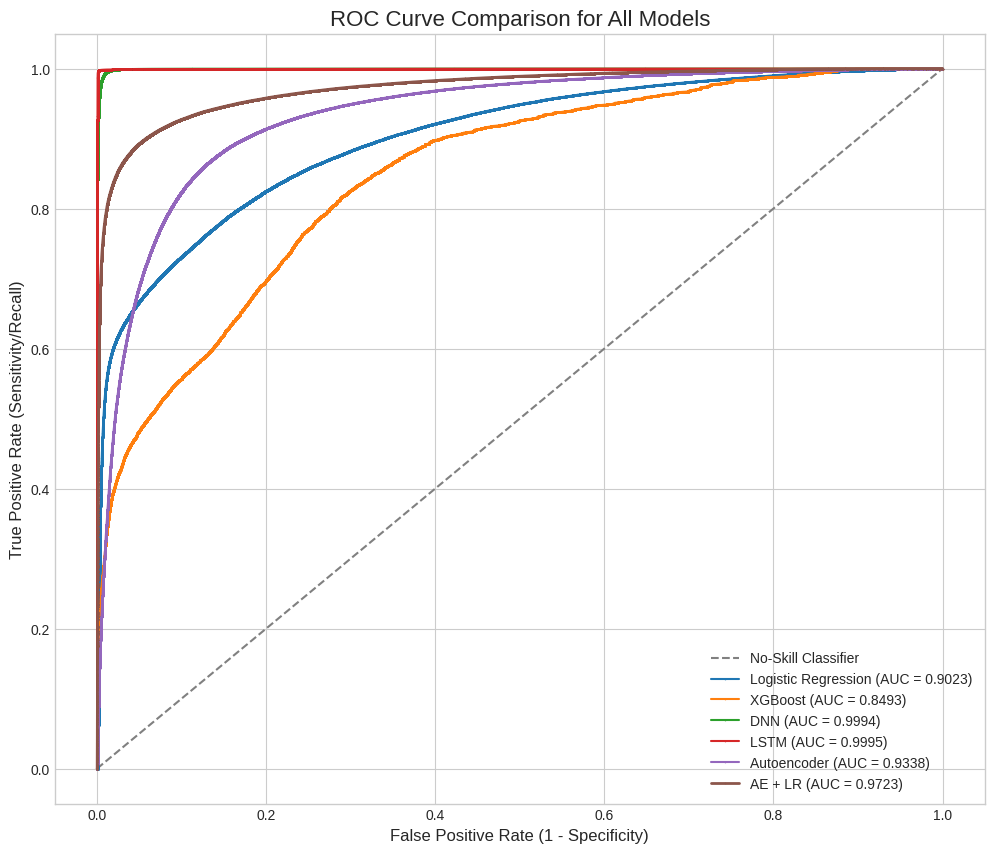

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- Create a single plot for all ROC Curves ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))

# --- Plot the "No-Skill" line (a random classifier) ---
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='No-Skill Classifier')


# --- Plotting each model's ROC curve ---

# Model 1: Logistic Regression (Original)
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
auc = roc_auc_score(y_test, y_score_lr)
plt.plot(fpr, tpr, marker='.', markersize=0.5, label=f'Logistic Regression (AUC = {auc:.4f})')

# Model 2: XGBoost
fpr, tpr, _ = roc_curve(y_test, y_score_xgb)
auc = roc_auc_score(y_test, y_score_xgb)
plt.plot(fpr, tpr, marker='.', markersize=0.5, label=f'XGBoost (AUC = {auc:.4f})')

# Model 3: DNN
fpr, tpr, _ = roc_curve(y_test, y_score_dnn)
auc = roc_auc_score(y_test, y_score_dnn)
plt.plot(fpr, tpr, marker='.', markersize=0.5, label=f'DNN (AUC = {auc:.4f})')

# Model 4: LSTM
# Note: Using the sequence labels (y_test_seq_labels)
fpr, tpr, _ = roc_curve(y_test_seq_labels, y_score_lstm)
auc = roc_auc_score(y_test_seq_labels, y_score_lstm)
plt.plot(fpr, tpr, marker='.', markersize=0.5, label=f'LSTM (AUC = {auc:.4f})')

# Model 5: Autoencoder
# Note: Using the sequence labels
fpr, tpr, _ = roc_curve(y_test_seq_labels, y_score_ae)
auc = roc_auc_score(y_test_seq_labels, y_score_ae)
plt.plot(fpr, tpr, marker='.', markersize=0.5, label=f'Autoencoder (AUC = {auc:.4f})')

# Model 7: Logistic Regression (Enhanced)
# Note: Using the sequence labels
fpr, tpr, _ = roc_curve(y_test_seq_labels, y_score_lr_enhanced)
auc = roc_auc_score(y_test_seq_labels, y_score_lr_enhanced)
plt.plot(fpr, tpr, marker='.', markersize=0.5, lw=2, label=f'AE + LR (AUC = {auc:.4f})')


# --- Finalize and show the plot ---
plt.title('ROC Curve Comparison for All Models', fontsize=16)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

             Confusion Matrix for Each Model


--- Logistic Regression (Original) ---
Confusion Matrix:
[[507724  39210]
 [107138 247212]]

Breakdown:
  - True Negatives (TN): 507724 (Correctly identified as Not Fraud)
  - False Positives (FP): 39210 (Incorrectly identified as Fraud)
  - False Negatives (FN): 107138 (Fraud transactions MISSED)
  - True Positives (TP): 247212 (Correctly identified as Fraud)




--- XGBoost ---
Confusion Matrix:
[[454962  91972]
 [124737 229613]]

Breakdown:
  - True Negatives (TN): 454962 (Correctly identified as Not Fraud)
  - False Positives (FP): 91972 (Incorrectly identified as Fraud)
  - False Negatives (FN): 124737 (Fraud transactions MISSED)
  - True Positives (TP): 229613 (Correctly identified as Fraud)


--- DNN ---
Confusion Matrix:
[[542271   4663]
 [  2962 351388]]

Breakdown:
  - True Negatives (TN): 542271 (Correctly identified as Not Fraud)
  - False Positives (FP): 4663 (Incorrectly identified as Fraud)
  - False Negatives (FN): 2962 (Fraud transactions MISSED)
  - True Positives (TP): 351388 (Correctly identified as Fraud)


--- LSTM ---
Confusion Matrix:
[[544471   1106]
 [  1003 353216]]

Breakdown:
  - True Negatives (TN): 544471 (Correctly identified as Not Fraud)
  - False Positives (FP): 1106 (Incorrectly identified as Fraud)
  - False Negatives (FN): 1003 (Fraud transactions MISSED)
  - True Positives (TP): 353216 (Correctly identifi

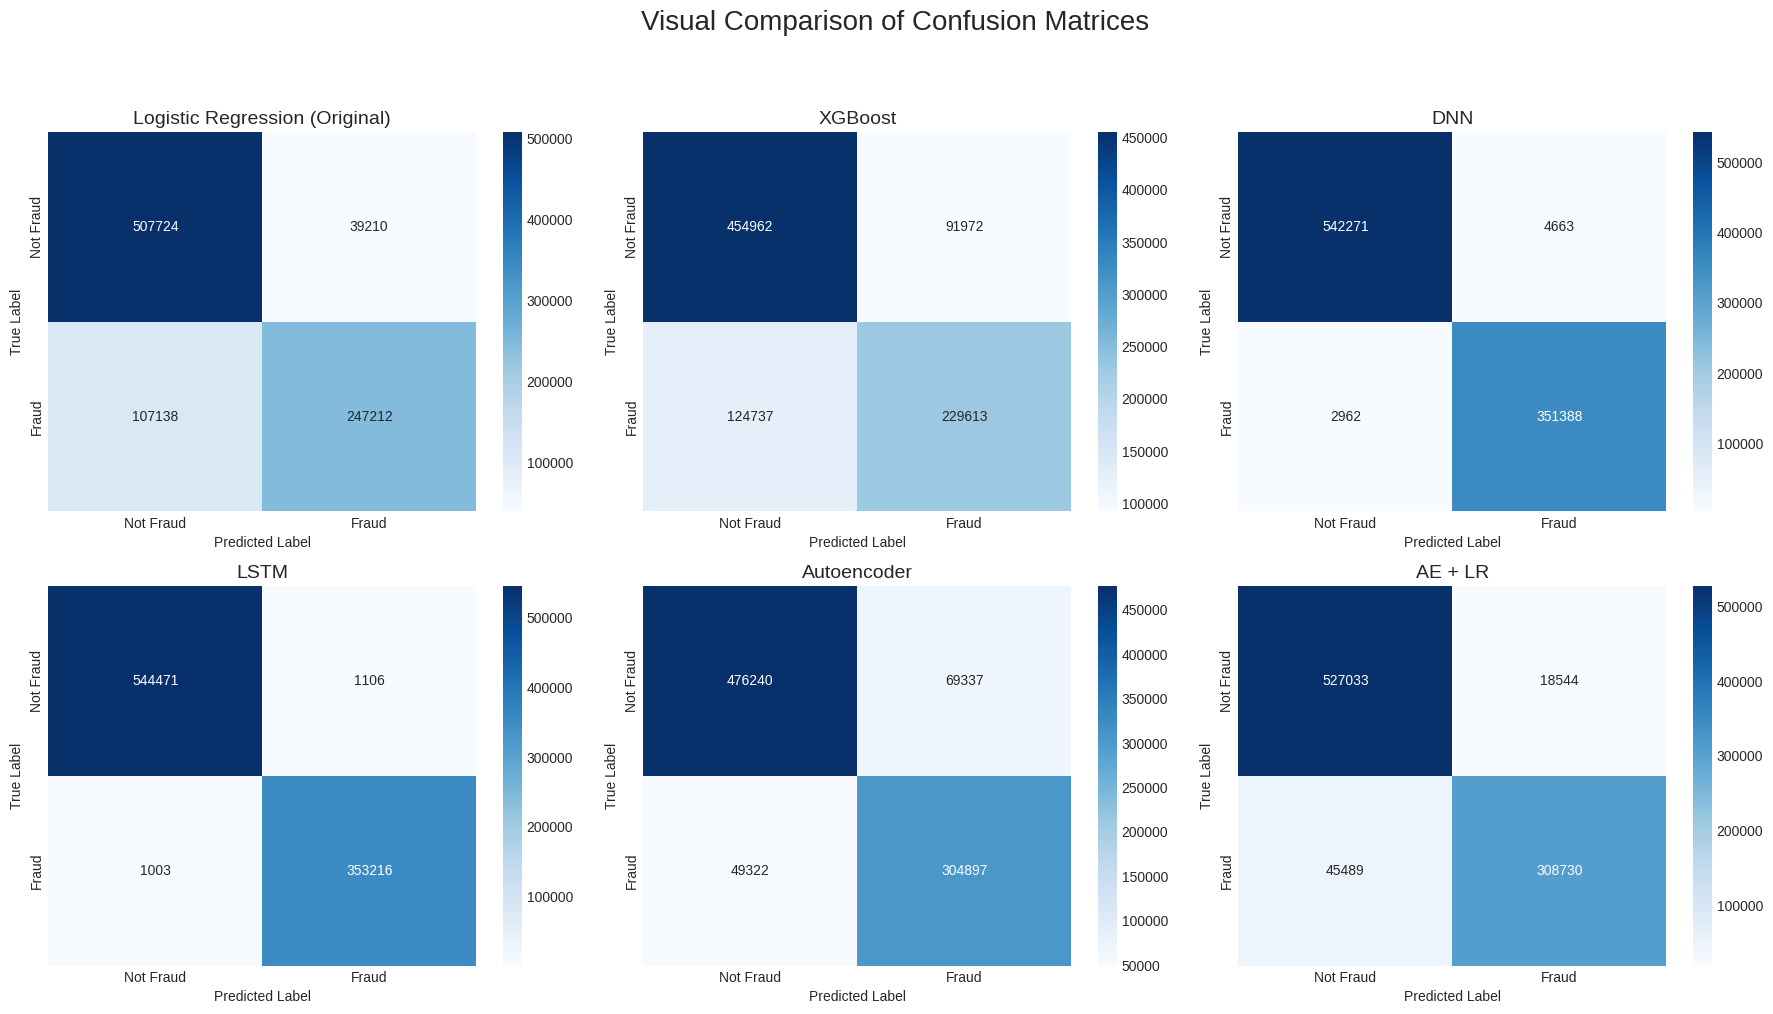

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- We will use the true labels and predicted labels generated earlier for each model ---

# Create a list containing the necessary data for each model
# Each tuple is (model_name, y_true, y_pred)
model_results = [
    ("Logistic Regression (Original)", y_test, y_pred_lr),
    ("XGBoost", y_test, y_pred_xgb),
    ("DNN", y_test, y_pred_dnn),
    ("LSTM", y_test_seq_labels, y_pred_lstm),
    ("Autoencoder", y_test_seq_labels, y_pred_ae),
    ("AE + LR", y_test_seq_labels, y_pred_lr_enhanced)
]

# --- Loop through each model's results and print its confusion matrix ---

print("="*50)
print("             Confusion Matrix for Each Model")
print("="*50)

# Create a subplot grid for visual comparison
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, (model_name, y_true, y_pred) in enumerate(model_results):
    print(f"\n\n--- {model_name} ---")
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print the standard matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Unpack the values for detailed printing
    try:
        tn, fp, fn, tp = cm.ravel()
        print("\nBreakdown:")
        print(f"  - True Negatives (TN): {tn} (Correctly identified as Not Fraud)")
        print(f"  - False Positives (FP): {fp} (Incorrectly identified as Fraud)")
        print(f"  - False Negatives (FN): {fn} (Fraud transactions MISSED)")
        print(f"  - True Positives (TP): {tp} (Correctly identified as Fraud)")
    except ValueError:
        print("\nCould not unpack matrix. It might be a 1x1 matrix if only one class was predicted.")

    # Plot the heatmap on the corresponding subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    axes[i].set_title(model_name, fontsize=14)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

# Hide any unused subplots
for j in range(len(model_results), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Visual Comparison of Confusion Matrices", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

     Individual Confusion Matrix for Each Model


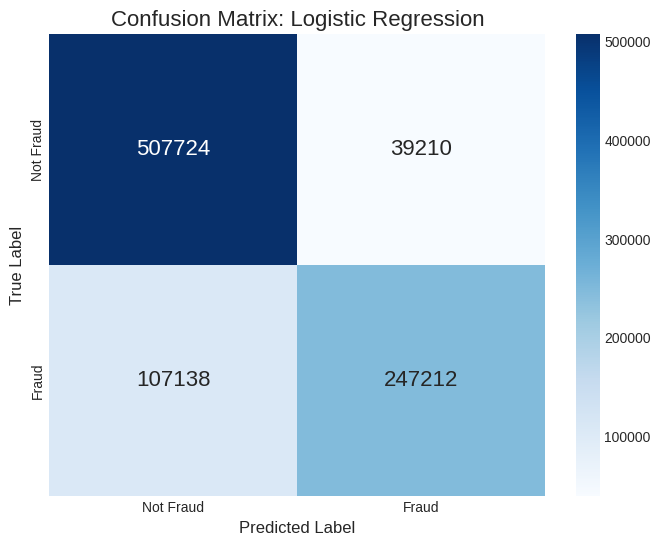


--- Logistic Regression Breakdown ---
  - True Negatives (TN): 507724
  - False Positives (FP): 39210
  - False Negatives (FN): 107138  <-- Critical Metric
  - True Positives (TP): 247212
------------------------------


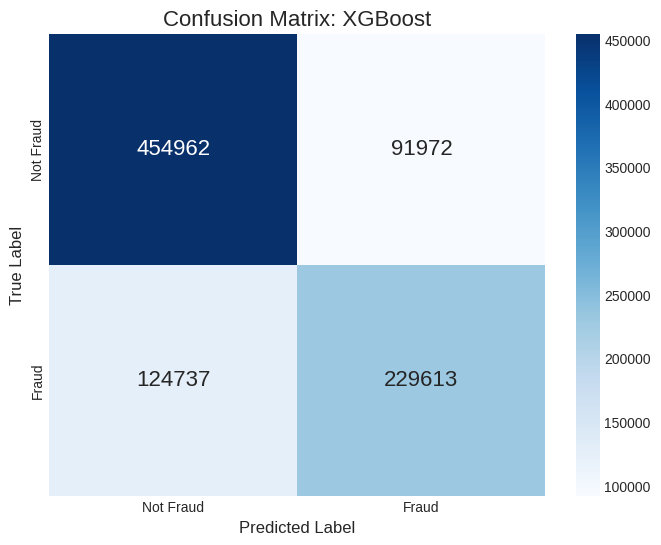


--- XGBoost Breakdown ---
  - True Negatives (TN): 454962
  - False Positives (FP): 91972
  - False Negatives (FN): 124737  <-- Critical Metric
  - True Positives (TP): 229613
------------------------------


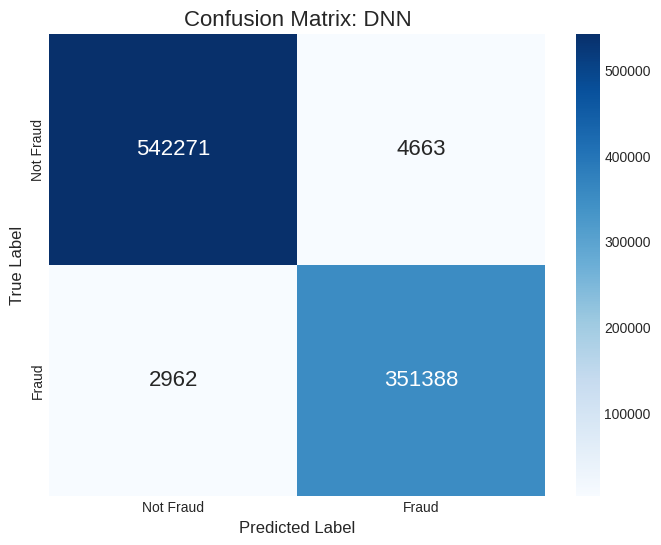


--- DNN Breakdown ---
  - True Negatives (TN): 542271
  - False Positives (FP): 4663
  - False Negatives (FN): 2962  <-- Critical Metric
  - True Positives (TP): 351388
------------------------------


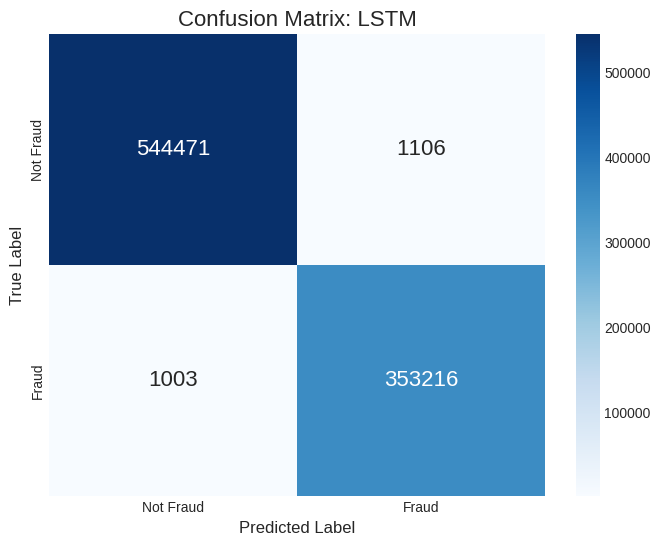


--- LSTM Breakdown ---
  - True Negatives (TN): 544471
  - False Positives (FP): 1106
  - False Negatives (FN): 1003  <-- Critical Metric
  - True Positives (TP): 353216
------------------------------


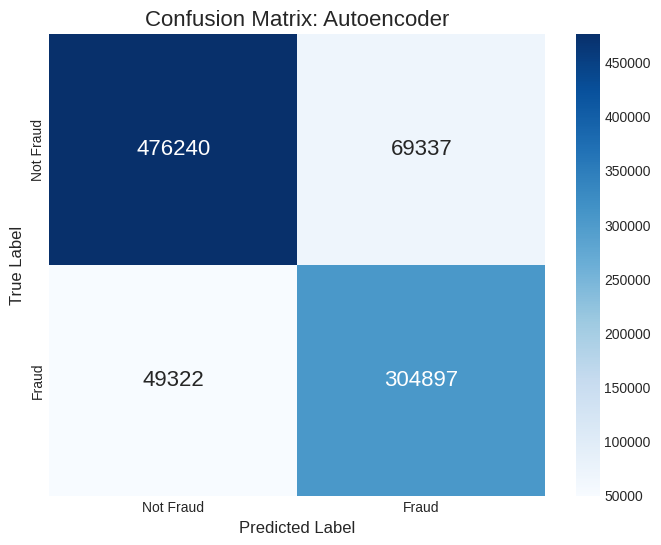


--- Autoencoder Breakdown ---
  - True Negatives (TN): 476240
  - False Positives (FP): 69337
  - False Negatives (FN): 49322  <-- Critical Metric
  - True Positives (TP): 304897
------------------------------


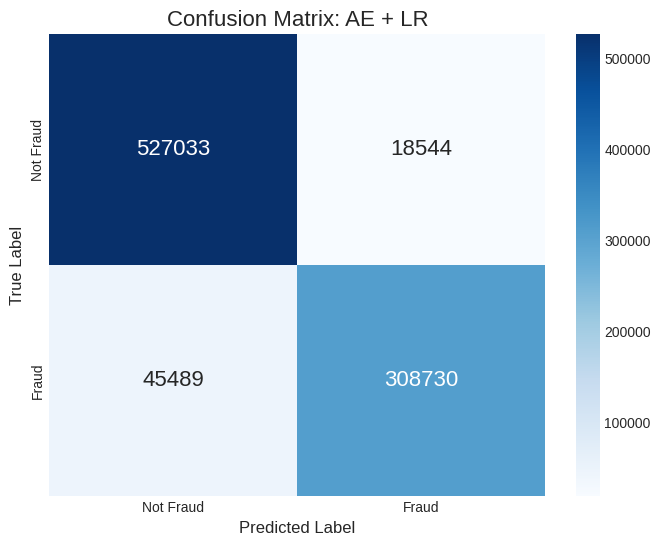


--- AE + LR Breakdown ---
  - True Negatives (TN): 527033
  - False Positives (FP): 18544
  - False Negatives (FN): 45489  <-- Critical Metric
  - True Positives (TP): 308730
------------------------------


In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- We will use the true labels and predicted labels generated earlier for each model ---

# Create a list containing the necessary data for each model
# Each tuple is (model_name, y_true, y_pred)
model_results = [
    ("Logistic Regression", y_test, y_pred_lr),
    ("XGBoost", y_test, y_pred_xgb),
    ("DNN", y_test, y_pred_dnn),
    ("LSTM", y_test_seq_labels, y_pred_lstm),
    ("Autoencoder", y_test_seq_labels, y_pred_ae),
    ("AE + LR", y_test_seq_labels, y_pred_lr_enhanced)
]

# --- Loop through each model's results and generate a separate plot ---

print("="*50)
print("     Individual Confusion Matrix for Each Model")
print("="*50)


for model_name, y_true, y_pred in model_results:
    # --- Create a new figure for each plot ---
    # This ensures each confusion matrix is its own image.
    plt.figure(figsize=(8, 6))
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Fraud', 'Fraud'], 
                yticklabels=['Not Fraud', 'Fraud'],
                annot_kws={"size": 16}) # Increase font size for readability
    
    plt.title(f'Confusion Matrix: {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Display the plot. A new image will be generated for each iteration.
    plt.show()
    
    # --- Also print the text breakdown for clarity ---
    print(f"\n--- {model_name} Breakdown ---")
    try:
        tn, fp, fn, tp = cm.ravel()
        print(f"  - True Negatives (TN): {tn}")
        print(f"  - False Positives (FP): {fp}")
        print(f"  - False Negatives (FN): {fn}  <-- Critical Metric")
        print(f"  - True Positives (TP): {tp}")
        print("-" * 30)
    except ValueError:
        print("Could not unpack matrix. It might be a 1x1 matrix if only one class was predicted.")